In [1]:
import os, glob, csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import gamma, multivariate_normal, rankdata
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics.pairwise import sigmoid_kernel, rbf_kernel, laplacian_kernel
from sklearn.metrics.pairwise import chi2_kernel, polynomial_kernel
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import BayesianGaussianMixture

from scipy.special import binom, comb
from scipy.spatial.distance import chebyshev

from itertools import combinations
import itertools

from time import time
from matplotlib import rc

# #rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex = True)

plt.rcParams['axes.facecolor'] = 'whitesmoke'

# This is the path to data (stract inside Sim* files)
path_to_data   = r"/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/"
path_to_images = r"/Users/Guille/Desktop/extreme_scenarios/images/depth/"

In [2]:
# Load csv avoiding errors in the headers
def __read_csv_file(file_name):
    with open(file_name) as _file:
        rows_ = []
        for row in csv.reader(_file, delimiter = ','):
            row = np.asarray(row)[:, np.newaxis]
            rows_.append(row)
    rows_.pop(0)
    return np.concatenate(rows_, axis = 1).T

L_, S_, W_, N_, Y_ = [], [], [], [], []

# Find All Simulations per Dates/Folders
files_ = glob.glob(path_to_data + r'*')
for file in files_:
    print(file)
            
    L_.append( __read_csv_file(file + '/LoadScenariosAggregated.csv').astype(np.float_)[..., np.newaxis] )
    S_.append( __read_csv_file(file + '/SolarScenariosAggregated.csv').astype(np.float_)[..., np.newaxis] )
    W_.append( __read_csv_file(file + '/WindScenariosAggregated.csv').astype(np.float_)[..., np.newaxis] )
    Y_.append( __read_csv_file(file + '/VaticOutput.csv').astype(np.float_)[..., np.newaxis] )
    N_.append( L_[-1] - S_[-1] - W_[-1] )

L_ = np.concatenate(L_, axis = -1)
S_ = np.concatenate(S_, axis = -1)
W_ = np.concatenate(W_, axis = -1)
N_ = np.concatenate(N_, axis = -1)
Y_ = np.concatenate(Y_, axis = -1)
print(L_.shape, S_.shape, W_.shape, N_.shape, Y_.shape)

/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Jul09
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Jun04
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/May27
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Dec19
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Feb16
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Nov20
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Sep04
/Users/Guille/Desktop/extreme_scenarios/data/ProcessedDataTexas/Jan20
(1000, 24, 8) (1000, 24, 8) (1000, 24, 8) (1000, 24, 8) (1000, 4, 8)


0


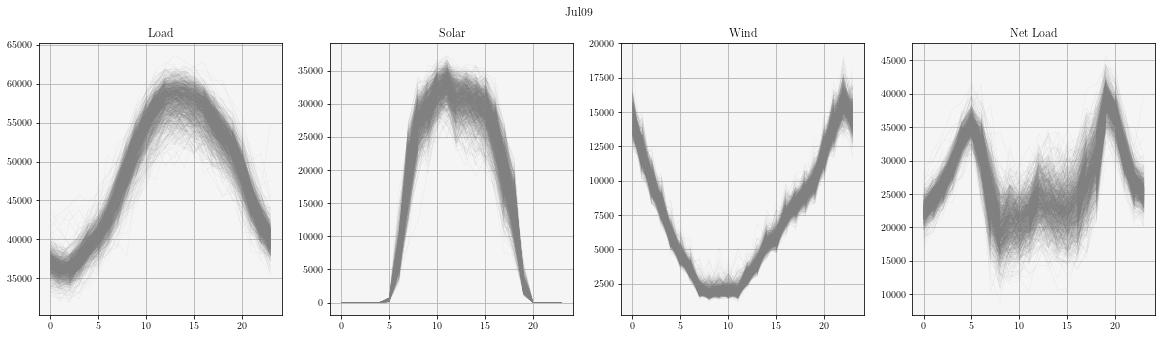

1


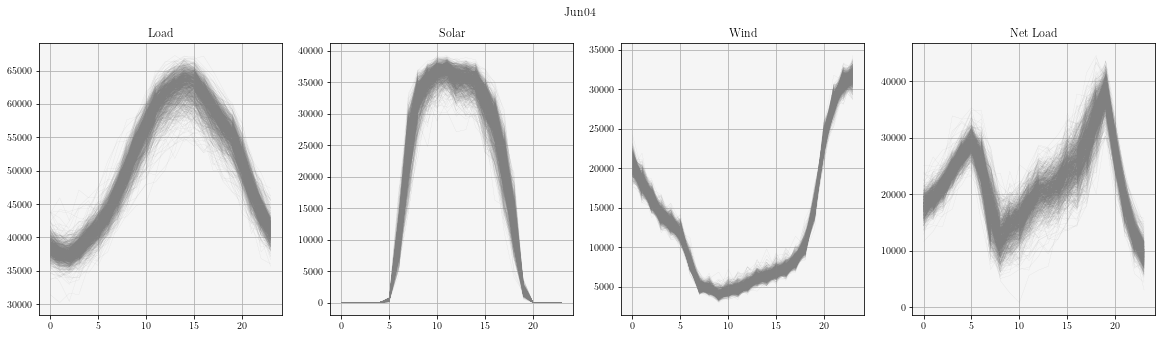

2


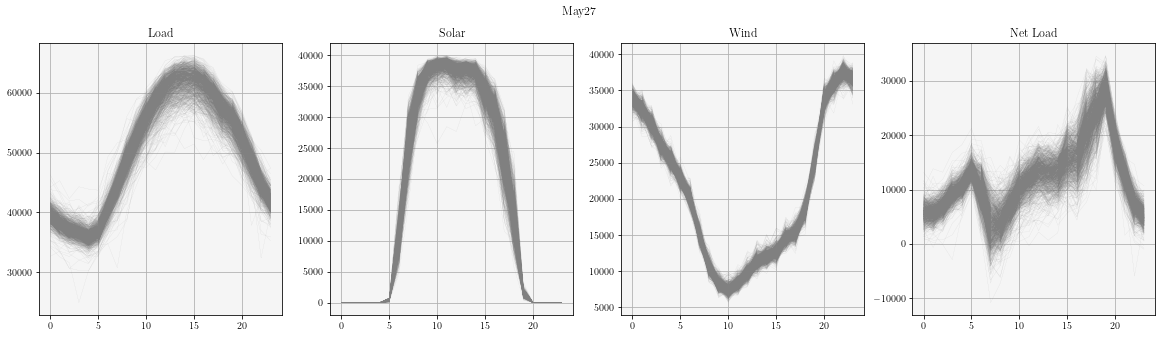

3


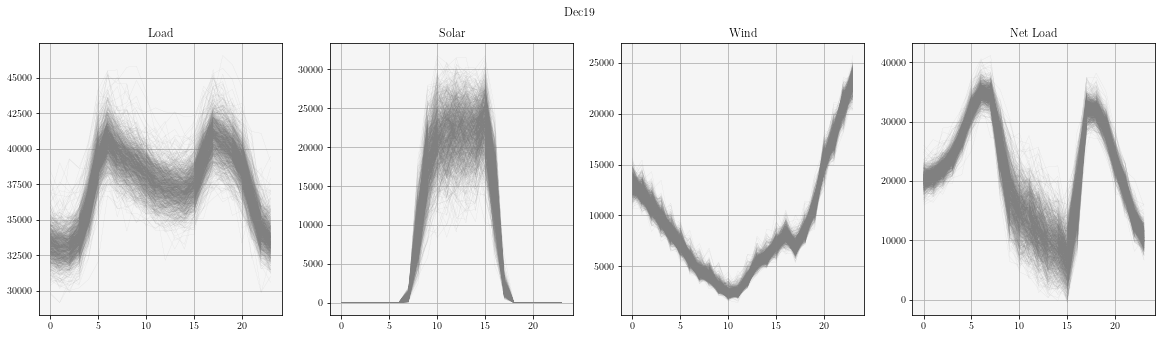

4


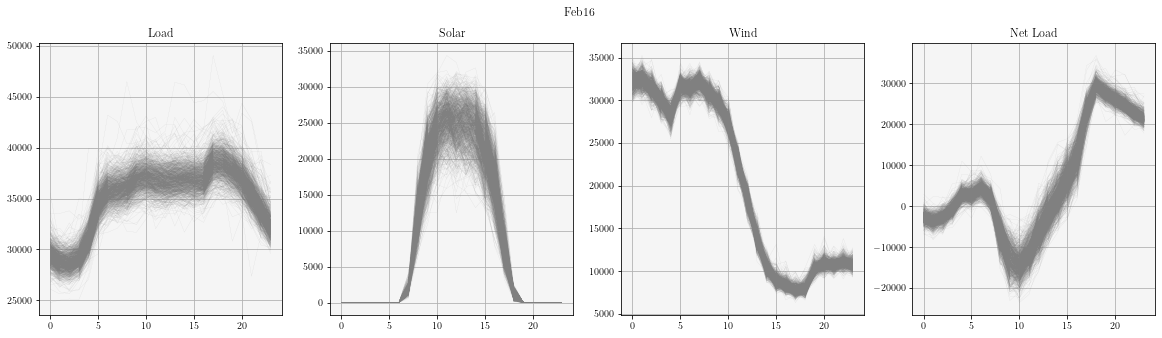

5


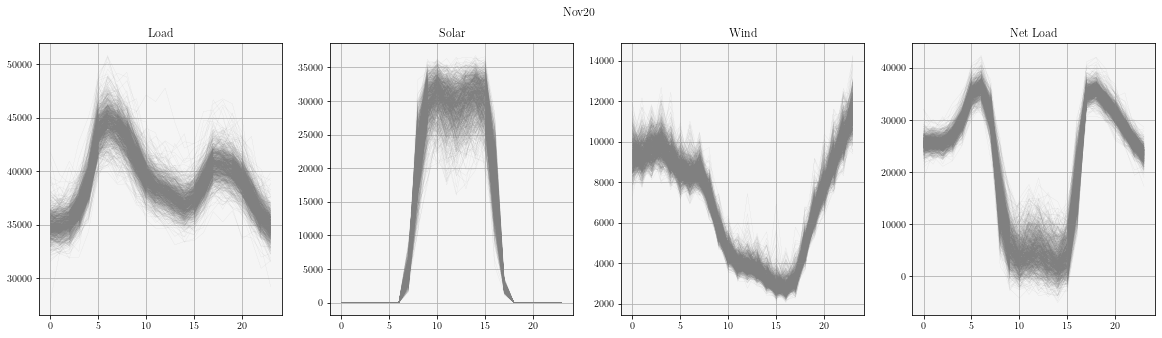

6


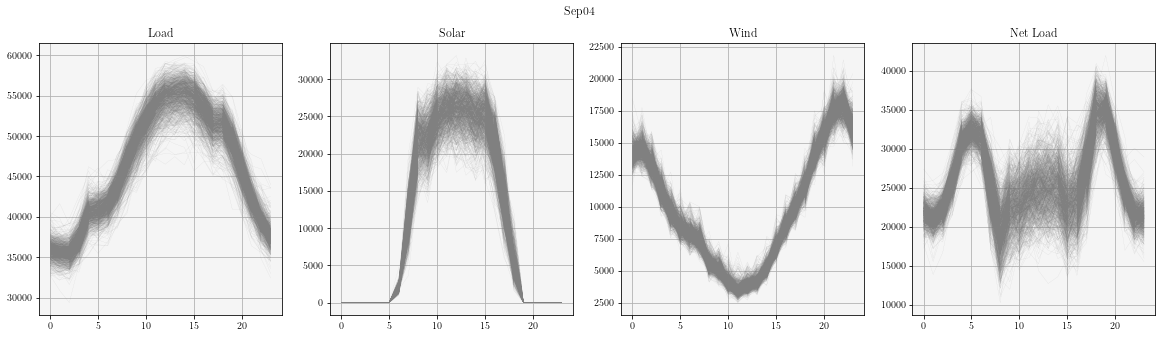

7


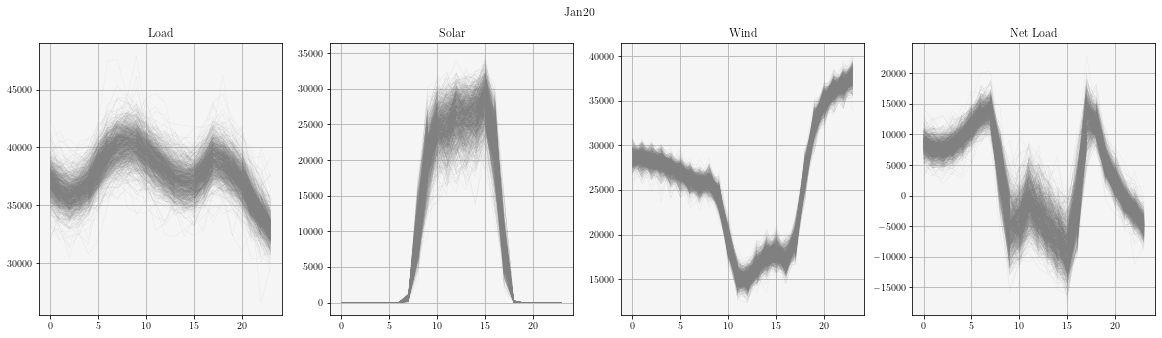

In [3]:
for i_date in range(L_.shape[-1]):
    print(i_date)
    
    plt.figure(figsize = (20, 5))
    plt.suptitle(files_[i_date][-5:])
    plt.subplot(141)
    plt.title("Load")
    plt.plot(L_[..., i_date].T, c = 'gray', linewidth = .05)
    plt.grid()

    plt.subplot(142)
    plt.title("Solar")
    plt.plot(S_[..., i_date].T, c = 'gray', linewidth = .05)
    plt.grid()
    
    plt.subplot(143)
    plt.title("Wind")
    plt.plot(W_[..., i_date].T, c = 'gray', linewidth = .05)
    plt.grid()
    
    plt.subplot(144)
    plt.title("Net Load")
    plt.plot(N_[..., i_date].T, c = 'gray', linewidth = .05)
    plt.grid()
    plt.show()

In [4]:
def _score(S_, S_hat_):
    return len(np.intersect1d(S_, S_hat_))

def _samples(S_, S_hat_, N_extreme):
    def __score(S_, S_hat_):
        S_correct_ = np.intersect1d(S_, S_hat_)
        return len(S_correct_)/S_.shape[0]
    
    for i in range(S_hat_.shape[0]):
        f = __score(S_[:N_extreme], S_hat_[:N_extreme + i])
        if f == 1.: 
            return N_extreme + i

N_extreme   = 50
N_scenarios = 1000
N_hours     = 24
N_days      = L_.shape[-1]

data_ = [L_, S_, W_, N_, S_ + W_]

# Evaluate Heuristic Performances

In [5]:
def _area_rank(X_, lowest = True):
    x_ = np.sum(X_, axis = -1)
    if lowest:
        return np.argsort(x_)
    else:
        return np.argsort(x_)[::-1]

def _ramp_rank(X_, dt, lowest = True):
    
    dX_ = np.absolute(np.diff(X_, dt, axis = 1))
    dx_ = np.sum(dX_, axis = -1)
    if lowest:
        return np.argsort(dx_)
    else:
        return np.argsort(dx_)[::-1]

def _hour_rank(X_, lowest = True):
    
    mu_    = np.mean(X_, axis = 0)
    M_     = np.repeat(mu_[np.newaxis, :], X_.shape[0], axis = 0)
    hours_ = np.sum(X_ > M_, axis = 1)
    
    if lowest:
        return np.argsort(hours_)
    else:
        return np.argsort(hours_)[::-1]

In [6]:
data_ = [L_, S_, W_, N_, S_ + W_]

F_11_ = np.zeros((len(data_), N_days, 8))
F_12_ = np.zeros((len(data_), N_days, 8))

for i in range(len(data_)):
    X_ = data_[i].copy()
    
    for j in range(N_days):
        S_ac_ = np.argsort(Y_[:, 0, j])[::-1]

        S_area_low_     = _area_rank(X_[..., j], lowest = True)
        F_11_[i, j, 0]  = _score(S_ac_[:N_extreme], S_area_low_[:N_extreme])
        F_12_[i, j, 0]  = _samples(S_ac_, S_area_low_, N_extreme)

        S_area_high_    = _area_rank(X_[..., j], lowest = False)
        F_11_[i, j, 1]  = _score(S_ac_[:N_extreme], S_area_high_[:N_extreme])
        F_12_[i, j, 1]  = _samples(S_ac_, S_area_high_, N_extreme)

        S_ramp_low_     = _ramp_rank(X_[..., j], dt = 1, lowest = True)
        F_11_[i, j, 2]  = _score(S_ac_[:N_extreme], S_ramp_low_[:N_extreme])
        F_12_[i, j, 2]  = _samples(S_ac_, S_ramp_low_, N_extreme)

        S_ramp_high_    = _ramp_rank(X_[..., j], dt = 1, lowest = False)
        F_11_[i, j, 3]  = _score(S_ac_[:N_extreme], S_ramp_high_[:N_extreme])
        F_12_[i, j, 3]  = _samples(S_ac_, S_ramp_high_, N_extreme)

        S_ramp_low_     = _ramp_rank(X_[..., j], dt = 3, lowest = True)
        F_11_[i, j, 4]  = _score(S_ac_[:N_extreme], S_ramp_low_[:N_extreme])
        F_12_[i, j, 4]  = _samples(S_ac_, S_ramp_low_, N_extreme)

        S_ramp_high_    = _ramp_rank(X_[..., j], dt = 3, lowest = False)
        F_11_[i, j, 5]  = _score(S_ac_[:N_extreme], S_ramp_high_[:N_extreme])
        F_12_[i, j, 5]  = _samples(S_ac_, S_ramp_high_, N_extreme)

        S_hour_low_     = _hour_rank(X_[..., j], lowest = True)
        F_11_[i, j, 6]  = _score(S_ac_[:N_extreme], S_hour_low_[:N_extreme])
        F_12_[i, j, 6]  = _samples(S_ac_, S_hour_low_, N_extreme)

        S_hour_high_    = _hour_rank(X_[..., j], lowest = False)
        F_11_[i, j, 7]  = _score(S_ac_[:N_extreme], S_hour_high_[:N_extreme])
        F_12_[i, j, 7]  = _samples(S_ac_, S_hour_high_, N_extreme)
        
print(np.mean(F_11_[0, ...], axis = 0), np.median(F_11_[0, ...], axis = 0))
print(np.mean(F_11_[1, ...], axis = 0), np.median(F_11_[1, ...], axis = 0))
print(np.mean(F_11_[2, ...], axis = 0), np.median(F_11_[2, ...], axis = 0))
print(np.mean(F_11_[3, ...], axis = 0), np.median(F_11_[3, ...], axis = 0))
print(np.mean(F_11_[4, ...], axis = 0), np.median(F_11_[4, ...], axis = 0))

print(np.mean(F_12_[0, ...], axis = 0), np.median(F_12_[0, ...], axis = 0))
print(np.mean(F_12_[1, ...], axis = 0), np.median(F_12_[1, ...], axis = 0))
print(np.mean(F_12_[2, ...], axis = 0), np.median(F_12_[2, ...], axis = 0))
print(np.mean(F_12_[3, ...], axis = 0), np.median(F_12_[3, ...], axis = 0))
print(np.mean(F_12_[4, ...], axis = 0), np.median(F_12_[4, ...], axis = 0))

[ 0.    38.375  0.75  11.75   1.375  9.     0.    24.125] [ 0.  38.5  0.  11.5  1.5  6.5  0.  24.5]
[2.5   1.875 3.25  1.875 1.625 2.75  2.    2.5  ] [2.5 2.  3.  1.5 1.5 2.  2.  2. ]
[2.375 1.75  1.875 2.75  2.625 2.875 2.375 2.125] [2.5 2.  2.  2.5 3.  2.5 2.5 2. ]
[ 0.    24.875  1.375  4.25   2.75   3.125  0.    22.875] [ 0.  24.   1.5  4.   2.   2.5  0.  23. ]
[2.75  1.875 2.    2.875 2.5   2.375 2.25  2.   ] [3.  2.  1.  2.5 2.5 2.  2.  1.5]
[1000.     137.375  993.625  910.375  990.375  950.     998.75   280.375] [1000.   121.   998.5  926.5  996.5  967.   999.   266.5]
[979.    982.    963.875 984.625 973.75  975.    987.25  969.75 ] [981.  983.5 974.  987.  988.  975.5 994.  974. ]
[967.875 979.625 985.375 976.75  985.    983.625 967.75  978.125] [975.5 988.5 988.5 979.  990.  989.5 982.5 981. ]
[999.875 392.375 988.875 963.    986.25  990.625 999.875 354.75 ] [1000.   354.   992.5  969.5  993.5  993.  1000.   340. ]
[983.875 984.    970.625 968.625 972.625 976.375 976.375 992

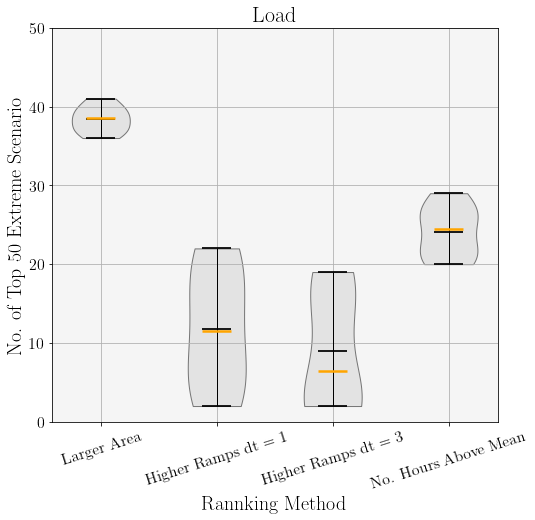

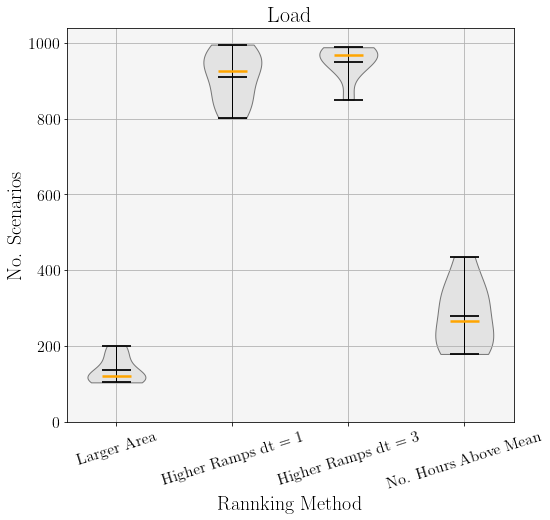

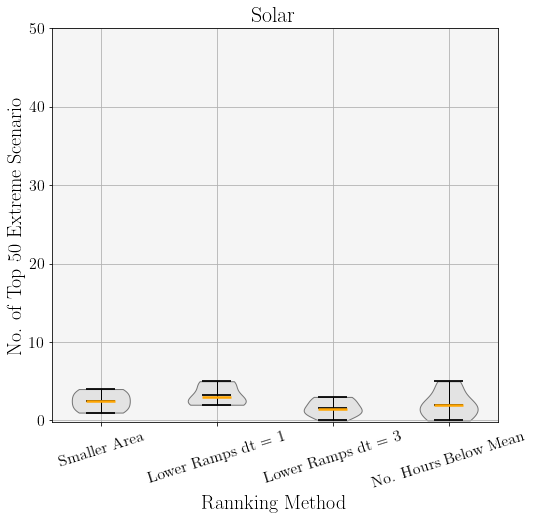

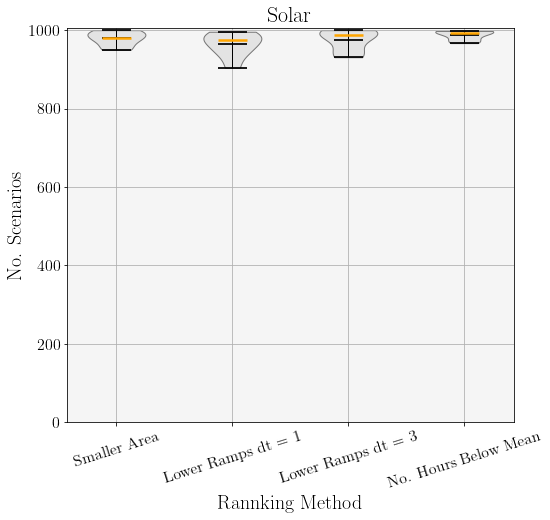

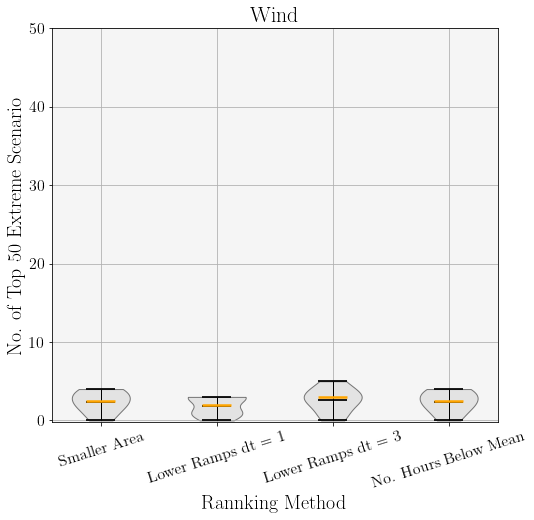

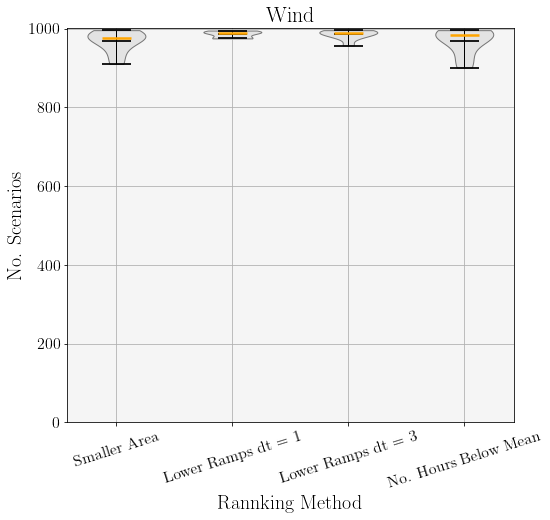

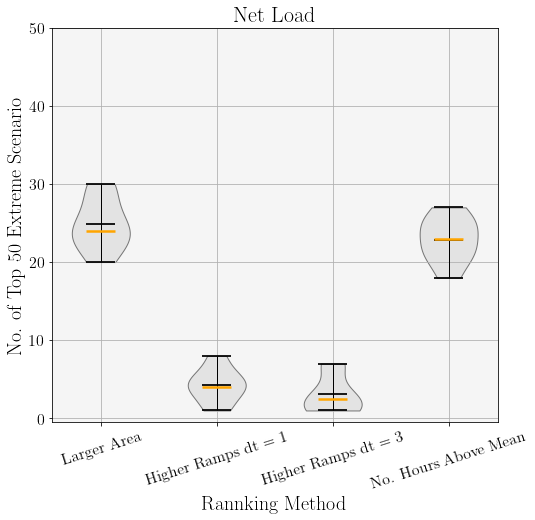

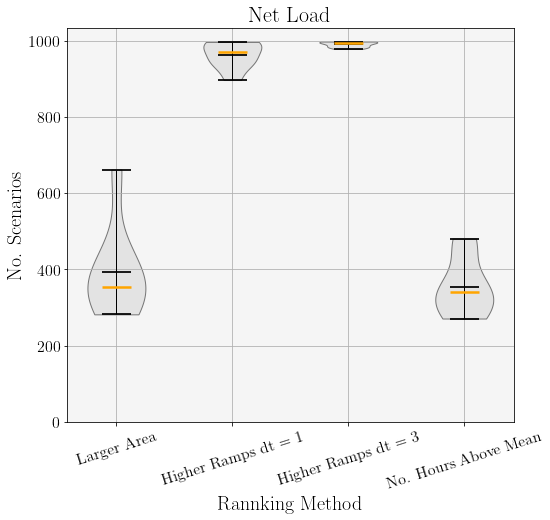

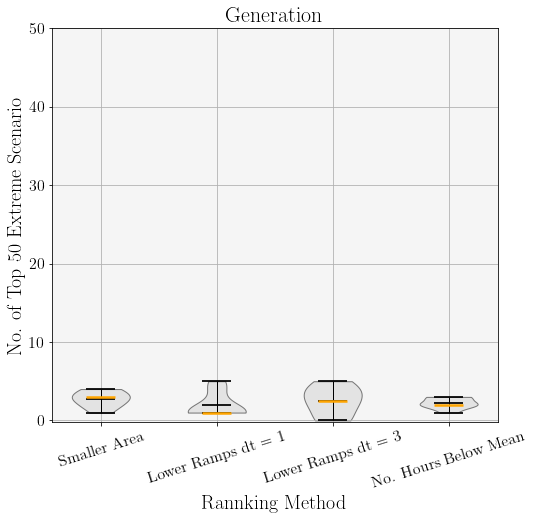

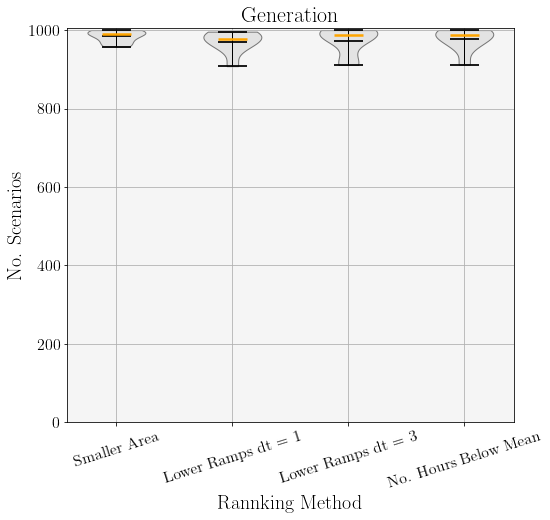

In [7]:
def _plot_violin_1(X_, names_, title):
    
    plt.figure(figsize = (8, 7.25))
    plt.title(title, fontsize = 22)

    violin_ = plt.violinplot(X_.T, showmeans = True, showextrema = True, showmedians = True)

    # Make all the violin statistics marks red:
    violin_['cbars'].set_edgecolor('black')
    violin_['cbars'].set_linewidth(1)

    violin_['cmins'].set_edgecolor('black')
    violin_['cmins'].set_linewidth(1.75)

    violin_['cmaxes'].set_edgecolor('black')
    violin_['cmaxes'].set_linewidth(1.75)

    violin_['cmeans'].set_edgecolor('black')
    violin_['cmeans'].set_linewidth(1.75)

    violin_['cmedians'].set_edgecolor('orange')
    violin_['cmedians'].set_linewidth(2.5)

    for _body in violin_['bodies']:
        _body.set_facecolor('lightgray')
        _body.set_edgecolor('black')
        _body.set_linewidth(1)
        _body.set_alpha(.5)

    plt.xlabel("Rannking Method", fontsize = 20)
    plt.ylabel("No. of Top 50 Extreme Scenario", fontsize = 20)
    plt.yticks(np.linspace(0., 50., 6), fontsize = 16)

    plt.xticks(np.linspace(1, len(names_), len(names_), dtype = int), names_, rotation = 17.5, fontsize = 16)

#     #name = r"Probs-{}.pdf".format(S_scenarios)

    plt.grid()
    #plt.savefig(path + name)
    plt.show()
    
def _plot_violin_2(X_, names_, title):
    
    plt.figure(figsize = (8, 7.25))
    plt.title(title, fontsize = 22)

    violin_ = plt.violinplot(X_.T, showmeans = True, showextrema = True, showmedians = True)

    # Make all the violin statistics marks red:
    violin_['cbars'].set_edgecolor('black')
    violin_['cbars'].set_linewidth(1)

    violin_['cmins'].set_edgecolor('black')
    violin_['cmins'].set_linewidth(1.75)

    violin_['cmaxes'].set_edgecolor('black')
    violin_['cmaxes'].set_linewidth(1.75)

    violin_['cmeans'].set_edgecolor('black')
    violin_['cmeans'].set_linewidth(1.75)

    violin_['cmedians'].set_edgecolor('orange')
    violin_['cmedians'].set_linewidth(2.5)

    for _body in violin_['bodies']:
        _body.set_facecolor('lightgray')
        _body.set_edgecolor('black')
        _body.set_linewidth(1)
        _body.set_alpha(.5)

    plt.xlabel("Rannking Method", fontsize = 20)
    plt.ylabel("No. Scenarios", fontsize = 20)
    plt.yticks(np.linspace(0., 1000., 6), fontsize = 16)

    plt.xticks(np.linspace(1, len(names_), len(names_), dtype = int), names_, rotation = 17.5, fontsize = 16)

#     #name = r"Probs-{}.pdf".format(S_scenarios)

    plt.grid()
    #plt.savefig(path + name)
    plt.show()
    
names_ = ['Smaller Area', 'Larger Area', 
          'Lower Ramps dt = 1', 'Higher Ramps dt = 1', 
          'Lower Ramps dt = 3', 'Higher Ramps dt = 3', 
          'No. Hours Below Mean', 'No. Hours Above Mean']
      
idx_l_ = [1, 3, 5, 7]
idx_s_ = [0, 2, 4, 6]
idx_w_ = [0, 2, 4, 6]
idx_n_ = [1, 3, 5, 7]
idx_g_ = [0, 2, 4, 6]

idx_    = [idx_l_, idx_s_, idx_w_, idx_n_, idx_g_]
titles_ = ['Load', 'Solar', 'Wind', 'Net Load', 'Generation']

for i in range(len(titles_)):
    _plot_violin_1(F_11_[i, :, idx_[i]], [names_[i] for i in idx_[i]], titles_[i])
    _plot_violin_2(F_12_[i, :, idx_[i]], [names_[i] for i in idx_[i]], titles_[i])

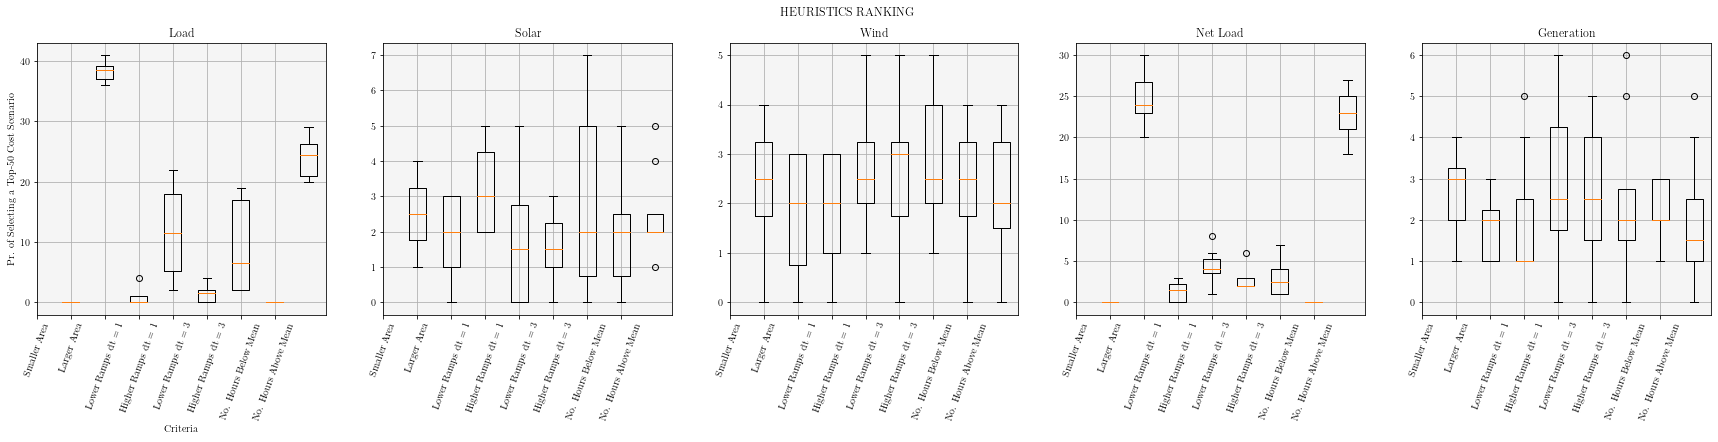

In [8]:
F_ = F_11_.copy()

plt.figure(figsize = (30, 5))
plt.suptitle('HEURISTICS RANKING')

plt.subplot(151)
plt.title('Load')
plt.boxplot([F_[0, :, i] for i in range(F_.shape[-1])])
plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
plt.xlabel('Criteria')
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.boxplot([F_[1, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.boxplot([F_[2, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(154)
plt.title('Net Load')
plt.boxplot([F_[3, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(155)
plt.title('Generation')
plt.boxplot([F_[4, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.show()

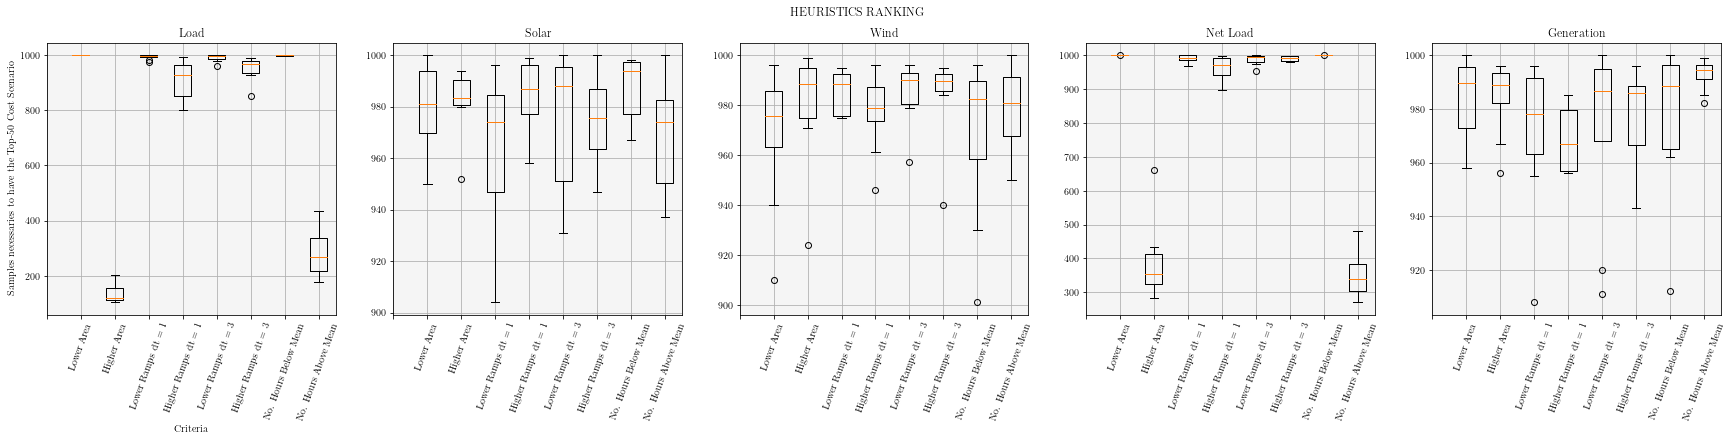

[1000.     137.375  993.625  910.375  990.375  950.     998.75   280.375] [1000.   121.   998.5  926.5  996.5  967.   999.   266.5]
[979.    982.    963.875 984.625 973.75  975.    987.25  969.75 ] [981.  983.5 974.  987.  988.  975.5 994.  974. ]
[967.875 979.625 985.375 976.75  985.    983.625 967.75  978.125] [975.5 988.5 988.5 979.  990.  989.5 982.5 981. ]
[999.875 392.375 988.875 963.    986.25  990.625 999.875 354.75 ] [1000.   354.   992.5  969.5  993.5  993.  1000.   340. ]
[983.875 984.    970.625 968.625 972.625 976.375 976.375 992.75 ] [989.5 989.  978.  967.  986.5 986.  988.5 994.5]


In [9]:
F_ = F_12_.copy()

names_ = ['', 'Lower Area', 'Higher Area', 'Lower Ramps dt = 1', 'Higher Ramps dt = 1', 'Lower Ramps dt = 3', 'Higher Ramps dt = 3', 'No. Hours Below Mean', 'No. Hours Above Mean']

plt.figure(figsize = (30, 5))
plt.suptitle('HEURISTICS RANKING')

plt.subplot(151)
plt.title('Load')
plt.boxplot([F_[0, :, i] for i in range(F_.shape[-1])])
plt.ylabel('Samples necessaries to have the Top-50 Cost Scenario')
plt.xlabel('Criteria')
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.boxplot([F_[1, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.boxplot([F_[2, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()


plt.subplot(154)
plt.title('Net Load')
plt.boxplot([F_[3, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(155)
plt.title('Generation')
plt.boxplot([F_[4, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.show()

print(np.mean(F_[0, ...], axis = 0), np.median(F_[0, ...], axis = 0))
print(np.mean(F_[1, ...], axis = 0), np.median(F_[1, ...], axis = 0))
print(np.mean(F_[2, ...], axis = 0), np.median(F_[2, ...], axis = 0))
print(np.mean(F_[3, ...], axis = 0), np.median(F_[3, ...], axis = 0))
print(np.mean(F_[4, ...], axis = 0), np.median(F_[4, ...], axis = 0))

# Evaluate Functional Depth Performances

In [10]:
# Rank Functions by their Integrated Depth
def _ID(Y_):
    
    # Empirical Density Function
    def __EDF(y_, n):
        z_ = np.zeros((n,))
        for j in range(n,):
            z_[j] = (y_ < y_[j]).sum()
        return z_/n

    # Get Problem Dimensions
    N_hours, N_scenarios = Y_.shape
    
    Z_ = np.zeros((N_hours, N_scenarios))
    for i in range(N_hours):
        # d-dimension Empirical Density Function
        Z_[i, :] = __EDF(Y_[i, :], N_scenarios)

    id_       = 1. - np.sum(np.absolute(.5 - Z_), axis = 0)/N_hours
    id_rank_  = np.argsort(id_)
    
    return id_, id_rank_

def _BD(Y_):    

    N_hours, N_scenarios = Y_.shape

    rank_ = rankdata(Y_, method = 'average', axis = 1)
    down_ = np.min(rank_, axis = 0) - 1. 
    up_   = N_scenarios - np.max(rank_, axis = 0)

    bd_      = ((up_ * down_) + N_scenarios - 1)/binom(N_scenarios, 2)
    bd_rank_ = np.argsort(bd_)
    
    return bd_, bd_rank_

def _MBD(Y_):
    
    N_hours, N_scenarios = Y_.shape

    rank_ = rankdata(Y_, method = 'average', axis = 1)
    down_ = rank_ - 1. 
    up_   = N_scenarios - rank_

    mbd_      = (np.sum(down_ * up_, axis = 0)/(N_scenarios + N_hours - 1))/binom(N_scenarios, 2)
    mbd_rank_ = np.argsort(mbd_)

    return mbd_, mbd_rank_

def _LinfD(Y_): 
    N_hours, N_scenarios = Y_.shape
    
    D_ = np.zeros((N_scenarios, N_scenarios))
    for i in range(N_scenarios):
        y_ = Y_[:, i]
        for j in range(N_scenarios):
            y_prime_ = Y_[:, j]
        
            D_[i, j] = chebyshev(y_, y_prime_)
    
    lid_      = 1./(1. + np.mean(D_, axis = 1))
    lid_rank_ = np.argsort(lid_)
    return lid_, lid_rank_

def _ED(Y_):
    def __piecewise_depth(Y_, N_scenarios):
        depth_ = np.zeros(Y_.shape)
        for i in range(Y_.shape[1]):
            y_ = Y_[:, i]
            rank_ = rankdata(y_, method = 'average')
            depth_[:, i] = 1. - np.absolute(2.*rank_ - N_scenarios - 1)/N_scenarios
        return depth_

    N_hours, N_scenarios = Y_.shape

    depth_ = __piecewise_depth(Y_.T, N_scenarios)
    
    # Compute Probability Mass Function
    pmfs_  = np.zeros((2, N_scenarios))
    for j in range(N_scenarios):
        pmf_, freq_ = np.unique(depth_[j, :], return_counts = True)
        freq_  = freq_.astype('float64')
        freq_ /= N_hours

        pmfs_[0, j] = pmf_[0]
        pmfs_[1, j] = freq_[0]


    # Sort Depth Levels
    sort_depth_levels_ = np.sort(np.unique(pmfs_[0, :]))
    sort_detph_ = []
    for depth_level in sort_depth_levels_:

        idx_ = np.where(pmfs_[0, :] == depth_level)[0]

        if idx_.shape[0] > 1:
            sort_masses = np.argsort(pmfs_[1, :][idx_])[::-1]
            sort_detph_.append(idx_[sort_masses])
        else:
            sort_detph_.append(idx_)
            
    # Construct Ranking Vectors
    sort_depth_prime_ = []
    for sort_depth in sort_detph_:
        for sort_depth_prime in sort_depth:
            sort_depth_prime_.append(sort_depth_prime)
    sort_depth_prime_prime_ = np.array(sort_depth_prime_)   

    x_       = np.linspace(1, N_scenarios, N_scenarios)/N_scenarios
    ed_      = x_[np.argsort(sort_depth_prime_prime_)]
    ed_rank_ = np.argsort(ed_)
    return ed_, ed_rank_

# Directional quantile of the two-sided ERLD
def _DQ(Y_, method = 'two-sided test', q_ = [.025, .975]):
    
    N_hours, N_scenarios = Y_.shape
    
    # Detrend Functional Data
    M_       = np.repeat(np.mean(Y_, axis = 1)[:, np.newaxis], N_scenarios, axis = 1)
    Y_prime_ = Y_ - M_
    
    # Compute Quantile Statistics
    Q_       = np.quantile(Y_prime_, q_, axis = 1)
    Q_lower_ = np.repeat(Q_[0, :][:, np.newaxis], N_scenarios, axis = 1)
    Q_upper_ = np.repeat(Q_[1, :][:, np.newaxis], N_scenarios, axis = 1)

    #  DQ is the largest pointwise outlyingness
    DQ_              = np.zeros((N_hours, N_scenarios))
    idx_lower_       = Y_prime_ < 0.
    DQ_[idx_lower_]  = Y_prime_[idx_lower_]/np.absolute(Q_lower_[idx_lower_])
    DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])

    if method == 'small one-sided test':
#         dq_      = np.min(DQ_, axis = 0)
#         dq_rank_ = np.argsort(dq_)
        dq_      = np.max(DQ_, axis = 0)
        dq_rank_ = np.argsort(dq_)
    if method == 'large one-sided test':
        dq_      = np.max(DQ_, axis = 0)
        dq_rank_ = np.argsort(dq_)[::-1]
    if method == 'two-sided test':
        dq_      = np.max(np.absolute(DQ_), axis = 0)
        dq_rank_ = np.argsort(dq_)[::-1]
    return dq_, dq_rank_

# Extreme Rank Length Depth
def _ERLD(Y_, method):
    # left-tail stochastic ordering of the depth distributions
    def _stochastic_ordering(R_, depth_, i, j):
        N_hours, N_scenarios = R_.shape
        for k in range(N_hours):
            # j-th smaller than i-th
            if R_[k, i] > R_[k, j]:
                depth_[i] += 1
            # i-th smaller than j-th
            if R_[k, i] < R_[k, j]:
                depth_[j] += 1
            # Tied   
            if R_[k, i] == R_[k, j]:
                depth_[i] += .5
                depth_[j] += .5
        return depth_

    N_hours, N_scenarios = Y_.shape

    # pointwise ranks for each method 
    R_prime_ = rankdata(Y_, axis = 1, method = 'average')
    if method == 'small one-sided test':
        R_ = R_prime_.copy()
    if method == 'large one-sided test':
        R_ = N_scenarios + 1 - R_prime_
    if method == 'two-sided test':
        r_prime_ = R_prime_.flatten()[:, np.newaxis]
        r_       = np.min(np.concatenate((r_prime_, N_scenarios + 1 - r_prime_), axis = 1), axis = 1)
        R_       = r_.reshape(N_hours, N_scenarios)
    
    # The ERLD of the rank
    depth_ = np.zeros((N_scenarios,))

    for i in range(N_scenarios):
        for j in range(i, N_scenarios):
            depth_ = _stochastic_ordering(R_, depth_, i, j)
        
    erld_      = depth_/N_scenarios
    erld_rank_ = np.argsort(erld_)
    return erld_, erld_rank_

def _lesser_deepest(Y_sc_, id_rank_, N_extreme):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    j = 0
    k = 0
    id_rank_prime_ = np.zeros(id_rank_.shape)
    
    N_scenarios = id_rank_.shape[0]
    
    for i in id_rank_:

        if a_sc_[i] <= a_mu:
            id_rank_prime_[j] = i
            j += 1
        else:
            id_rank_prime_[N_scenarios - k - 1] = i
            k += 1
            
    return id_rank_prime_

def _geater_deepest(Y_sc_, id_rank_, N_extreme):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    j = 0
    k = 0
    id_rank_prime_ = np.zeros(id_rank_.shape)
    
    N_scenarios = id_rank_.shape[0]
    
    for i in id_rank_:

        if a_sc_[i] > a_mu:
            id_rank_prime_[j] = i
            j += 1
        else:
            id_rank_prime_[N_scenarios - k - 1] = i
            k += 1
            
    return id_rank_prime_

In [11]:
F_21_ = np.zeros((len(data_), N_days, 14))
F_22_ = np.zeros((len(data_), N_days, 14))

for i in range(len(data_)):
    X_ = data_[i].copy()
    print(i)
    
    for j in range(N_days):
        S_ac_ = np.argsort(Y_[:, 0, j])[::-1]

        id_score_, id_rank_     = _ID(X_[..., j].T)
        bd_score_, bd_rank_     = _BD(X_[..., j].T)
        mbd_score_, mbd_rank_   = _MBD(X_[..., j].T)
        ld_score_, ld_rank_     = _LinfD(X_[..., j].T)
        ed_score_, ed_rank_     = _ED(X_[..., j].T)
        erld_score_, erld_rank_ = _ERLD(X_[..., j].T, method = 'two-sided test')
        dq_score_, dq_rank_     = _DQ(X_[..., j].T, method = 'two-sided test', q_ = [.025, .975])

        id_rank_geater_ = _geater_deepest(X_[..., j].T, id_rank_, N_extreme)
        F_21_[i, j, 0]  = _score(S_ac_[:N_extreme], id_rank_geater_[:N_extreme])
        F_22_[i, j, 0]  = _samples(S_ac_, id_rank_geater_, N_extreme)

        id_rank_lesser_ = _lesser_deepest(X_[..., j].T, id_rank_, N_extreme)
        F_21_[i, j, 1]  = _score(S_ac_[:N_extreme], id_rank_lesser_[:N_extreme])
        F_22_[i, j, 1]  = _samples(S_ac_, id_rank_lesser_, N_extreme)

        bd_rank_geater_ = _geater_deepest(X_[..., j].T, bd_rank_, N_extreme)
        F_21_[i, j, 2]  = _score(S_ac_[:N_extreme], bd_rank_geater_[:N_extreme])
        F_22_[i, j, 2]  = _samples(S_ac_, bd_rank_geater_, N_extreme)

        bd_rank_lesser_ = _lesser_deepest(X_[..., j].T, bd_rank_, N_extreme)
        F_21_[i, j, 3]  = _score(S_ac_[:N_extreme], bd_rank_lesser_[:N_extreme])
        F_22_[i, j, 3]  = _samples(S_ac_, bd_rank_lesser_, N_extreme)

        mbd_rank_geater_ = _geater_deepest(X_[..., j].T, mbd_rank_, N_extreme)
        F_21_[i, j, 4]   = _score(S_ac_[:N_extreme], mbd_rank_geater_[:N_extreme])
        F_22_[i, j, 4]   = _samples(S_ac_, mbd_rank_geater_, N_extreme)
        
        mbd_rank_lesser_ = _lesser_deepest(X_[..., j].T, mbd_rank_, N_extreme)
        F_21_[i, j, 5]   = _score(S_ac_[:N_extreme], mbd_rank_lesser_[:N_extreme])
        F_22_[i, j, 5]   = _samples(S_ac_, mbd_rank_lesser_, N_extreme)
        
        ld_rank_geater_  = _geater_deepest(X_[..., j].T, ld_rank_, N_extreme)
        F_21_[i, j, 6]   = _score(S_ac_[:N_extreme], ld_rank_geater_[:N_extreme])
        F_22_[i, j, 6]   = _samples(S_ac_, ld_rank_geater_, N_extreme)

        ld_rank_lesser_  = _lesser_deepest(X_[..., j].T, ld_rank_, N_extreme)
        F_21_[i, j, 7]   = _score(S_ac_[:N_extreme], ld_rank_lesser_[:N_extreme])
        F_22_[i, j, 7]   = _samples(S_ac_, ld_rank_lesser_, N_extreme)

        ed_rank_geater_  = _geater_deepest(X_[..., j].T, ed_rank_, N_extreme)
        F_21_[i, j, 8]   = _score(S_ac_[:N_extreme], ed_rank_geater_[:N_extreme])
        F_22_[i, j, 8]   = _samples(S_ac_, ed_rank_geater_, N_extreme)

        ed_rank_lesser_  = _lesser_deepest(X_[..., j].T, ed_rank_, N_extreme)
        F_21_[i, j, 9]   = _score(S_ac_[:N_extreme], ed_rank_lesser_[:N_extreme])
        F_22_[i, j, 9]   = _samples(S_ac_, ed_rank_lesser_, N_extreme)
        
        erld_rank_geater_ = _geater_deepest(X_[..., j].T, erld_rank_, N_extreme)
        F_21_[i, j, 10]   = _score(S_ac_[:N_extreme], erld_rank_geater_[:N_extreme])
        F_22_[i, j, 10]   = _samples(S_ac_, erld_rank_geater_, N_extreme)
        
        erld_rank_lesser_ = _lesser_deepest(X_[..., j].T, erld_rank_, N_extreme)
        F_21_[i, j, 11]   = _score(S_ac_[:N_extreme], erld_rank_lesser_[:N_extreme])
        F_22_[i, j, 11]   = _samples(S_ac_, erld_rank_lesser_, N_extreme)

        dq_rank_geater_   = _geater_deepest(X_[..., j].T, dq_rank_, N_extreme)
        F_21_[i, j, 12]   = _score(S_ac_[:N_extreme], dq_rank_geater_[:N_extreme])
        F_22_[i, j, 12]   = _samples(S_ac_, dq_rank_geater_, N_extreme)

        dq_rank_lesser_   = _lesser_deepest(X_[..., j].T, dq_rank_, N_extreme)
        F_21_[i, j, 13]   = _score(S_ac_[:N_extreme], dq_rank_lesser_[:N_extreme])        
        F_22_[i, j, 13]   = _samples(S_ac_, dq_rank_lesser_, N_extreme)
        
print(np.mean(F_21_[0, ...], axis = 0), np.median(F_21_[0, ...], axis = 0))
print(np.mean(F_21_[1, ...], axis = 0), np.median(F_21_[1, ...], axis = 0))
print(np.mean(F_21_[2, ...], axis = 0), np.median(F_21_[2, ...], axis = 0))
print(np.mean(F_21_[3, ...], axis = 0), np.median(F_21_[3, ...], axis = 0))
print(np.mean(F_21_[4, ...], axis = 0), np.median(F_21_[4, ...], axis = 0))


print(np.mean(F_22_[0, ...], axis = 0), np.median(F_22_[0, ...], axis = 0))
print(np.mean(F_22_[1, ...], axis = 0), np.median(F_22_[1, ...], axis = 0))
print(np.mean(F_22_[2, ...], axis = 0), np.median(F_22_[2, ...], axis = 0))
print(np.mean(F_22_[3, ...], axis = 0), np.median(F_22_[3, ...], axis = 0))
print(np.mean(F_22_[4, ...], axis = 0), np.median(F_22_[4, ...], axis = 0))

0
1


<ipython-input-10-40730f79d96f>:132: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


KeyboardInterrupt: 

In [ ]:
def _plot_violin_1(X_, names_, title):
    
    plt.figure(figsize = (8, 7.25))
    plt.title(title, fontsize = 22)

    violin_ = plt.violinplot(X_.T, showmeans = True, showextrema = True, showmedians = True)

    # Make all the violin statistics marks red:
    violin_['cbars'].set_edgecolor('black')
    violin_['cbars'].set_linewidth(1)

    violin_['cmins'].set_edgecolor('black')
    violin_['cmins'].set_linewidth(1.75)

    violin_['cmaxes'].set_edgecolor('black')
    violin_['cmaxes'].set_linewidth(1.75)

    violin_['cmeans'].set_edgecolor('black')
    violin_['cmeans'].set_linewidth(1.75)

    violin_['cmedians'].set_edgecolor('orange')
    violin_['cmedians'].set_linewidth(2.5)

    for _body in violin_['bodies']:
        _body.set_facecolor('lightgray')
        _body.set_edgecolor('black')
        _body.set_linewidth(1)
        _body.set_alpha(.5)

    plt.xlabel("Rannking Method", fontsize = 20)
    plt.ylabel("No. of Top 50 Extreme Scenario", fontsize = 20)
    plt.yticks(np.linspace(0., 50., 6), fontsize = 16)

    plt.xticks(np.linspace(1, len(names_), len(names_), dtype = int), names_, rotation = 17.5, fontsize = 16)

#     #name = r"Probs-{}.pdf".format(S_scenarios)

    plt.grid()
    #plt.savefig(path + name)
    plt.show()
    
def _plot_violin_2(X_, names_, title):
    
    plt.figure(figsize = (8, 7.25))
    plt.title(title, fontsize = 22)

    violin_ = plt.violinplot(X_.T, showmeans = True, showextrema = True, showmedians = True)

    # Make all the violin statistics marks red:
    violin_['cbars'].set_edgecolor('black')
    violin_['cbars'].set_linewidth(1)

    violin_['cmins'].set_edgecolor('black')
    violin_['cmins'].set_linewidth(1.75)

    violin_['cmaxes'].set_edgecolor('black')
    violin_['cmaxes'].set_linewidth(1.75)

    violin_['cmeans'].set_edgecolor('black')
    violin_['cmeans'].set_linewidth(1.75)

    violin_['cmedians'].set_edgecolor('orange')
    violin_['cmedians'].set_linewidth(2.5)

    for _body in violin_['bodies']:
        _body.set_facecolor('lightgray')
        _body.set_edgecolor('black')
        _body.set_linewidth(1)
        _body.set_alpha(.5)

    plt.xlabel("Rannking Method", fontsize = 20)
    plt.ylabel("No. Scenarios", fontsize = 20)
    plt.yticks(np.linspace(0., 1000., 6), fontsize = 16)

    plt.xticks(np.linspace(1, len(names_), len(names_), dtype = int), names_, rotation = 17.5, fontsize = 16)

#     #name = r"Probs-{}.pdf".format(S_scenarios)

    plt.grid()
    #plt.savefig(path + name)
    plt.show()
    
names_ = ['Top-sided ID', 'Bottom-sided ID', 
          'Top-sided BD', 'Bottom-sided BD', 
          'Top-sided MBD', 'Bottom-sided MBD', 
          'Top-sided LD', 'Bottom-sided LD', 
          'Top-sided ED', 'Bottom-sided ED', 
          'Top-sided ERLD', 'Bottom-sided ERLD', 
          'Top-sided DQ', 'Bottom-sided DQ']
      
idx_l_ = [0, 2, 4, 6, 8, 10, 12]
idx_s_ = [1, 3, 5, 7, 9 , 11, 13]
idx_w_ = [1, 3, 5, 7, 9 , 11, 13]
idx_n_ = [0, 2, 4, 6, 8, 10, 12]
idx_g_ = [1, 3, 5, 7, 9 , 11, 13]

idx_    = [idx_l_, idx_s_, idx_w_, idx_n_, idx_g_]
titles_ = ['Load', 'Solar', 'Wind', 'Net Load', 'Generation']

for i in range(len(titles_)):
    _plot_violin_1(F_21_[i, :, idx_[i]], [names_[i] for i in idx_[i]], titles_[i])
    _plot_violin_2(F_22_[i, :, idx_[i]], [names_[i] for i in idx_[i]], titles_[i])

In [ ]:
F_ = F_21_.copy()

names_ = ['', 'Top-sided ID', 'Bottom-sided ID', 
              'Top-sided BD', 'Bottom-sided BD', 
              'Top-sided MBD', 'Bottom-sided MBD', 
              'Top-sided LD', 'Bottom-sided LD', 
              'Top-sided ED', 'Bottom-sided ED', 
              'Top-sided ERLD', 'Bottom-sided ERLD', 
              'Top-sided DQ', 'Bottom-sided DQ']

plt.figure(figsize = (30, 5))
plt.suptitle('FUNCTIONAL DEPTH RANKING')

plt.subplot(151)
plt.title('Load')
plt.boxplot([F_[0, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
plt.xlabel('Criteria')
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.boxplot([F_[1, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.boxplot([F_[2, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(154)
plt.title('Net Load')
plt.boxplot([F_[3, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(155)
plt.title('Generation')
plt.boxplot([F_[4, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()
plt.show()

In [ ]:
F_ = F_22_.copy()

names_ = ['', 'Top-sided ID', 'Bottom-sided ID', 
              'Top-sided BD', 'Bottom-sided BD', 
              'Top-sided MBD', 'Bottom-sided MBD', 
              'Top-sided LD', 'Bottom-sided LD', 
              'Top-sided ED', 'Bottom-sided ED', 
              'Top-sided ERLD', 'Bottom-sided ERLD', 
              'Top-sided DQ', 'Bottom-sided DQ']

plt.figure(figsize = (30, 5))
plt.suptitle('FUNCTIONAL DEPTH RANKING')

plt.subplot(151)
plt.title('Load')
plt.boxplot([F_[0, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.ylabel('Samples necessaries to have the Top-50 Cost Scenario')
plt.xlabel('Criteria')
plt.grid()

plt.subplot(152)
plt.title('Solar')
plt.boxplot([F_[1, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(153)
plt.title('Wind')
plt.boxplot([F_[2, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()


plt.subplot(154)
plt.title('Net Load')
plt.boxplot([F_[3, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.subplot(155)
plt.title('Generation')
plt.boxplot([F_[4, :, i] for i in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_))), names_, rotation = 70)
plt.grid()

plt.show()

# Proposed Methods Perfomance Evaluation

In [ ]:
def _score(S_, S_hat_):
    S_correct_ = np.intersect1d(S_, S_hat_)
    return len(S_correct_)


def _deepest(Y_sc_, id_rank_):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    j = 0
    k = 0
    id_rank_prime_ = np.zeros(id_rank_.shape)
    
    N_scenarios = id_rank_.shape[0]
    
    for i in id_rank_:

        if a_sc_[i] > a_mu:
            id_rank_prime_[j] = i
            j += 1
        else:
            id_rank_prime_[N_scenarios - k - 1] = i
            k += 1
            
    return id_rank_prime_.astype(int)

def _select_extreme_samples(X_0_, X_1_, X_2_, X_3_, N_scenarios, Q_scenarios, P_scenarios, F_scenarios):
    
    # Empirical Density Function
    def __EDF(y_):
        n = y_.shape[0]
        z_ = np.zeros((n,))
        for j in range(n,):
            z_[j] = (y_ < y_[j]).sum()
        return z_/n
    
    
    F_scenarios = S_scenarios
    rate        = F_scenarios/100.
    
    if F_scenarios > 100.:
        P_scenarios = int(P_scenarios*rate) 
        Q_scenarios = int(Q_scenarios*rate) 
        N_scenarios = int(N_scenarios*rate) 

    X_4_ = X_1_ + X_2_
    idx_ = np.linspace(0, X_0_.shape[-1] - 1, X_0_.shape[-1], dtype = int)

    x_0_score_, x_0_rank_ = _MBD(X_0_)
    x_1_score_, x_1_rank_ = _MBD(X_1_)
    x_2_score_, x_2_rank_ = _MBD(X_2_)
        
    x_0_rank_ = np.argsort(x_0_score_)
    x_0_rank_ = _deepest(X_0_, x_0_rank_)
    i_sel_    = x_0_rank_[:N_scenarios]
    
    idx_prime_ = idx_[i_sel_]
    
    X_0_sel_ = X_0_[:, i_sel_]
    X_1_sel_ = X_1_[:, i_sel_]
    X_2_sel_ = X_2_[:, i_sel_]
    X_3_sel_ = X_3_[:, i_sel_]
    X_4_sel_ = X_4_[:, i_sel_]
    
    x_0_score_, x_0_rank_ = _MBD(X_0_sel_)
    x_1_score_, x_1_rank_ = _MBD(X_1_sel_)
    x_2_score_, x_2_rank_ = _MBD(X_2_sel_)
    x_3_score_, x_3_rank_ = _MBD(X_3_sel_)
    x_4_score_, x_4_rank_ = _MBD(X_4_sel_)

    x_prime_rank_ = np.argsort(x_1_score_ * x_2_score_)
    x_prime_rank_ = _deepest(X_0_sel_, x_prime_rank_)
    i_sel_        = x_prime_rank_[:Q_scenarios]
    
    idx_prime_prime_ = idx_prime_[i_sel_]

    X_0_sel_ = X_0_sel_[:, i_sel_]
        
    #area_  = np.sum(X_0_sel_, axis = 0)
    area_ = np.sum(X_0_sel_.T > np.repeat(np.mean(X_0_sel_.T, axis = 0)[np.newaxis, :], X_0_sel_.shape[1], axis = 0), axis = 1)

    x_prime_rank_ = np.argsort(__EDF(area_))[::-1]
    i_sel_        = x_prime_rank_[:P_scenarios]

    idx_prime_prime_prime_ = idx_prime_prime_[i_sel_]

    X_0_sel_ = X_0_sel_[:, i_sel_]
    
    area_  = np.sum(X_0_sel_, axis = 0)
    #area_ = np.sum(X_0_sel_.T > np.repeat(np.mean(X_0_sel_.T, axis = 0)[np.newaxis, :], X_0_sel_.shape[1], axis = 0), axis = 1)

    x_prime_rank_ = np.argsort(__EDF(area_))[::-1]
    #i_sel_        = x_prime_rank_[:100]

    idx_prime_prime_prime_prime_ = idx_prime_prime_prime_[x_prime_rank_][:F_scenarios]
    
    return idx_prime_, idx_prime_prime_, idx_prime_prime_prime_, idx_prime_prime_prime_prime_


N_extreme   = 50

S_scenarios_ = [50, 100, 150, 200]
N_days       = L_.shape[-1]
scores_      = np.zeros((len(S_scenarios_), N_days, 5))

for S_scenarios, i_scanarios in zip(S_scenarios_, range(len(S_scenarios_))):
    for i_day in range(N_days):

        X_0_ = L_[..., i_day].T 
        X_1_ = S_[..., i_day].T 
        X_2_ = W_[..., i_day].T 
        X_3_ = N_[..., i_day].T 
        X_4_ = X_1_ + X_2_

        Y_0_ = Y_[:, 0, i_day]
        Y_1_ = Y_[:, 1, i_day]
        Y_2_ = Y_[:, 2, i_day]
        Y_3_ = Y_[:, 3, i_day]

        #idx_s_ = np.argsort(Y_1_)[::-1]
        #N_s    = np.sum(Y_1_ > 0.)
        #idx_c_ = np.argsort(Y_3_)[::-1]

        idx_e_0_, idx_e_1_, idx_e_2_, idx_e_3_ = _select_extreme_samples(X_0_, X_1_, X_2_, X_3_, N_scenarios = 175, Q_scenarios = 150, P_scenarios = 125, F_scenarios = S_scenarios)

        idx_c_                         = np.argsort(Y_0_)
        scores_[i_scanarios, i_day, 0] = _score(idx_c_[-N_extreme:], idx_e_3_)

        x_0_score_, x_0_rank_ = _MBD(X_0_)
        idx_mbd_ = _deepest(X_0_, x_0_rank_)[:S_scenarios]
        scores_[i_scanarios, i_day, 1] = _score(idx_c_[-N_extreme:], idx_mbd_)

        x_1_score_, x_1_rank_ = _MBD(X_1_)
        x_2_score_, x_2_rank_ = _MBD(X_2_)
        idx_sw_ = np.argsort(x_1_score_ * x_2_score_)
        idx_sw_ = _deepest(X_0_, idx_sw_)[:S_scenarios]
        scores_[i_scanarios, i_day, 2] = _score(idx_c_[-N_extreme:], idx_sw_)

        idx_h_ = np.argsort(np.sum(X_0_.T > np.repeat(np.mean(X_0_.T, axis = 0)[np.newaxis, :], X_0_.shape[1], axis = 0), axis = 1))[-S_scenarios:]
        scores_[i_scanarios, i_day, 3] = _score(idx_c_[-N_extreme:], idx_h_)

        idx_a_ = np.argsort(np.sum(X_0_, axis = 0))[-S_scenarios:]
        scores_[i_scanarios, i_day, 4] = _score(idx_c_[-N_extreme:], idx_a_)
        print(i_day, S_scenarios, scores_[i_scanarios, i_day, :])

    print(np.mean(scores_[i_scanarios, ...], axis = 0))
    
# [37.625 36.5    5.25  24.125 38.375]
# [47.625 46.25  11.    39.125 46.875]
# [49.125 48.875 15.625 45.    49.375]
# [50.    49.75  20.375 47.125 49.875]

In [ ]:
for S_scenarios, i_scanarios in zip(S_scenarios_, range(len(S_scenarios_))):

    plt.figure(figsize = (8, 7.25))
    plt.title("No. of Top 50 Extreme Scenarios in {} Samples".format(S_scenarios), fontsize = 22)
    violin_ = plt.violinplot(scores_[i_scanarios, ...], showmeans = True, showextrema = True, showmedians = True)

    # Make all the violin statistics marks red:
    violin_['cbars'].set_edgecolor('black')
    violin_['cbars'].set_linewidth(1)

    violin_['cmins'].set_edgecolor('black')
    violin_['cmins'].set_linewidth(1.75)

    violin_['cmaxes'].set_edgecolor('black')
    violin_['cmaxes'].set_linewidth(1.75)

    violin_['cmeans'].set_edgecolor('black')
    violin_['cmeans'].set_linewidth(1.75)

    violin_['cmedians'].set_edgecolor('orange')
    violin_['cmedians'].set_linewidth(2.5)

    for _body in violin_['bodies']:
        _body.set_facecolor('lightgray')
        _body.set_edgecolor('black')
        _body.set_linewidth(1)
        _body.set_alpha(.5)

    plt.xlabel("Rannking Method", fontsize = 20)
    plt.ylabel("No. of Top 50 Extreme Scenario", fontsize = 20)
    plt.yticks(np.linspace(0., 50., 6), fontsize = 16)

    names_ = ['Proposed', 'MBD (Load)', 'MBD (Solar \& Wind)',  'No. Hours (Load)', 'Area (Load)']
    plt.xticks([1, 2, 3, 4, 5], names_, rotation = 17.5, fontsize = 16)
    
    name = r"Probs-{}.pdf".format(S_scenarios)
    
    plt.grid()
    plt.savefig(path_to_images + name)
    plt.show()

0 Jul. 09 81
1 Jun. 04 73
2 May. 27 80


<ipython-input-13-44bad65f2360>:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (8.4, 7.5))


3 Dec. 19 81
4 Feb16 85
5 Nov. 20 81
6 Sep. 4 75
7 Jan. 20 85


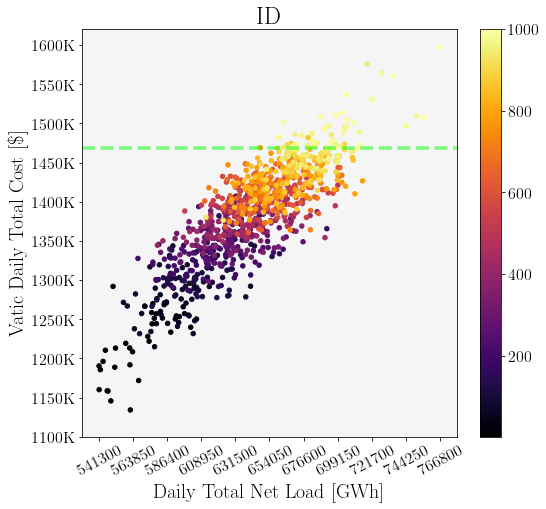

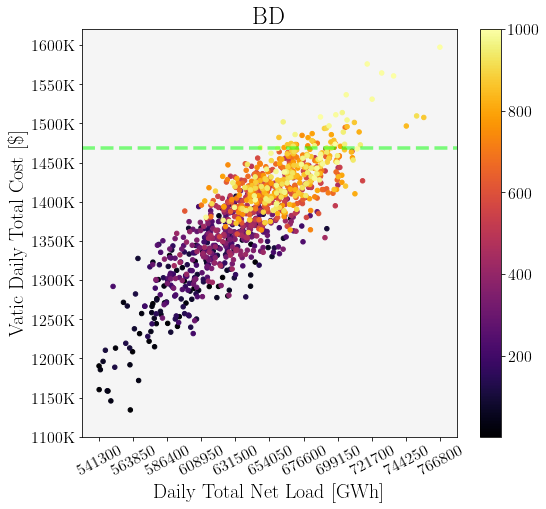

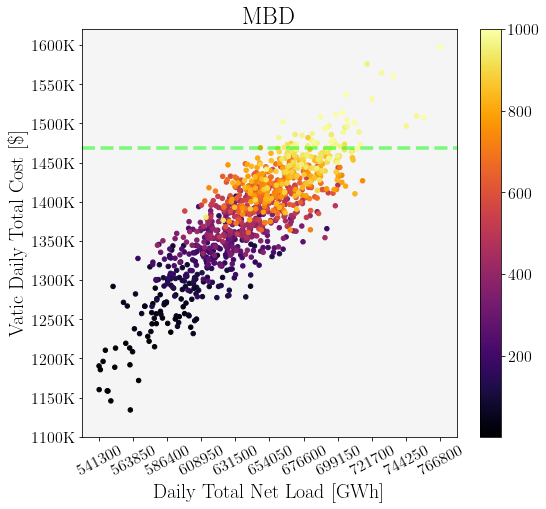

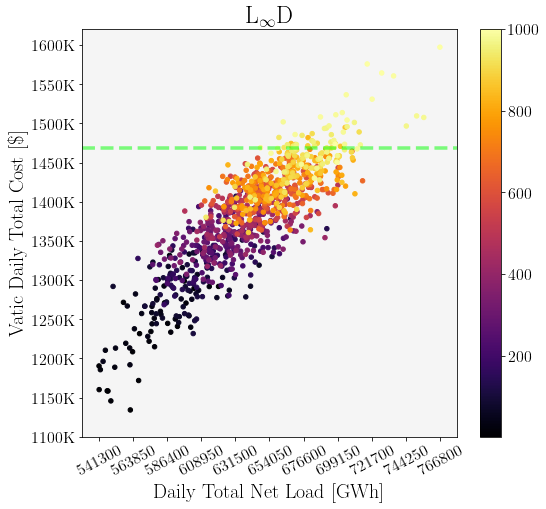

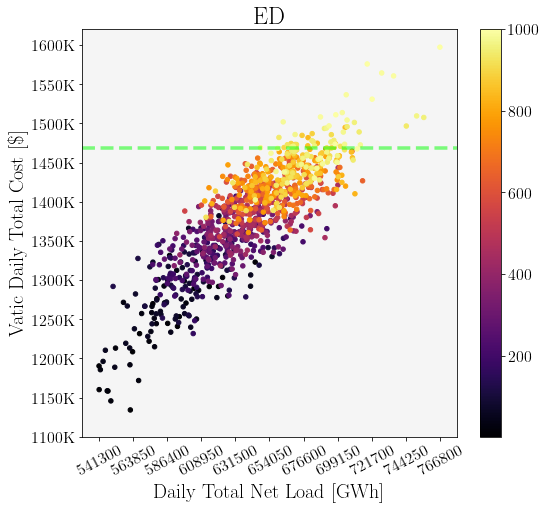

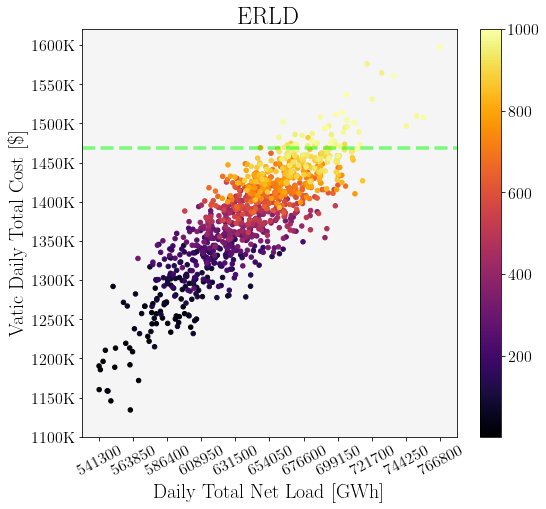

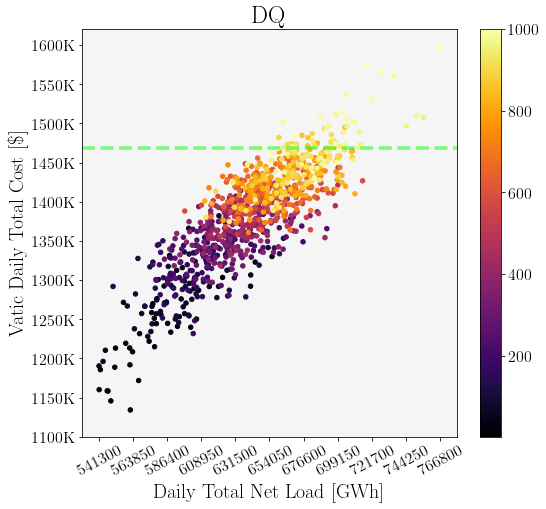

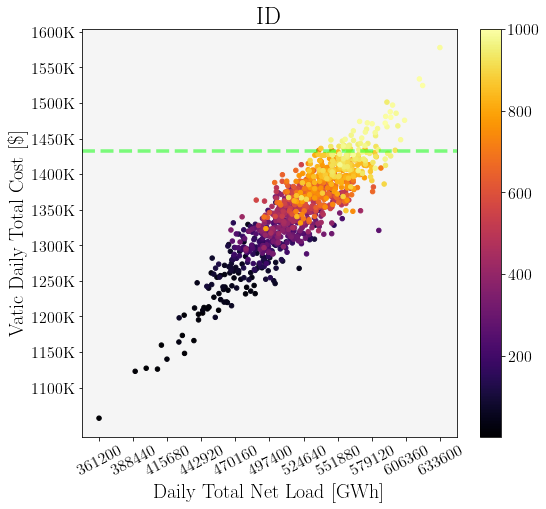

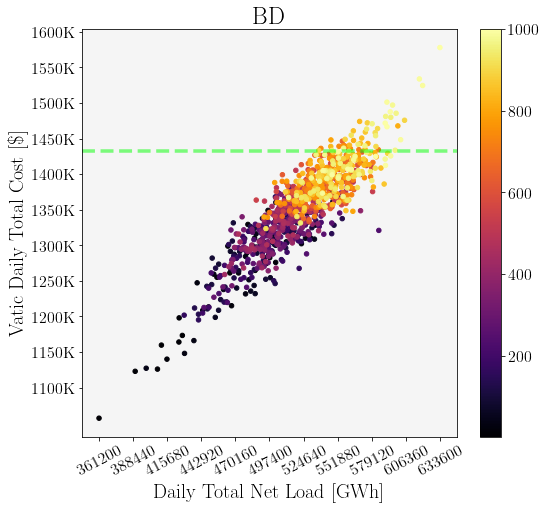

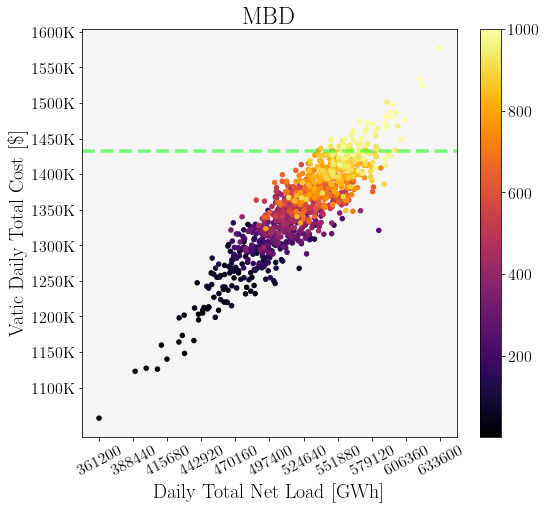

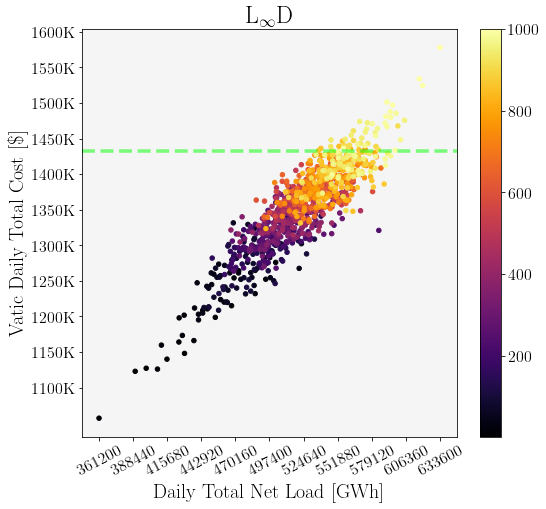

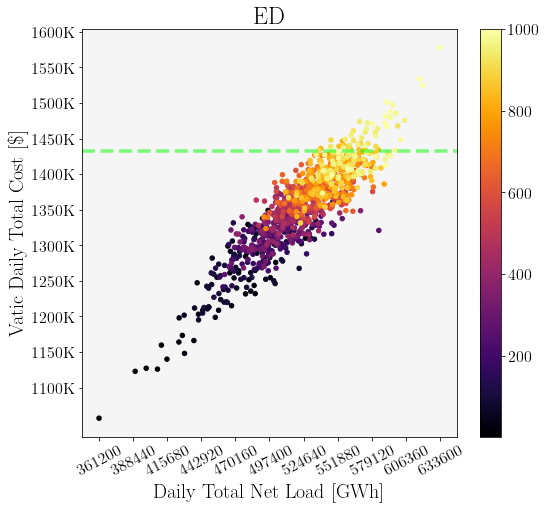

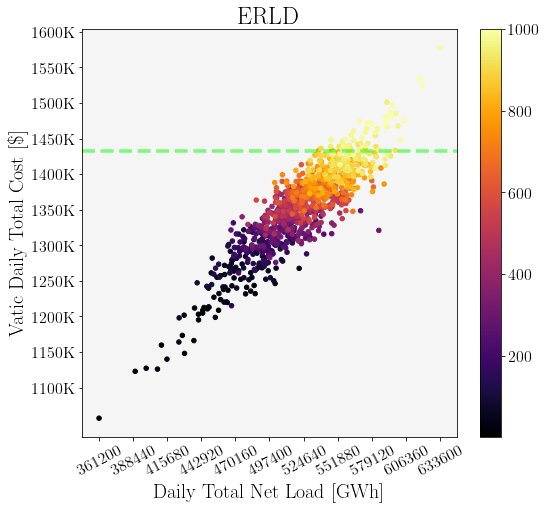

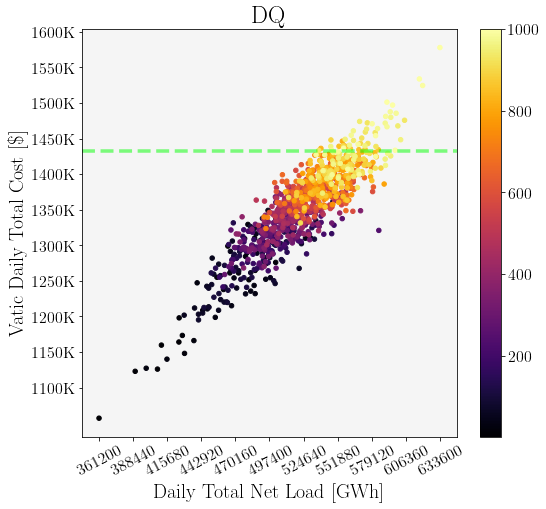

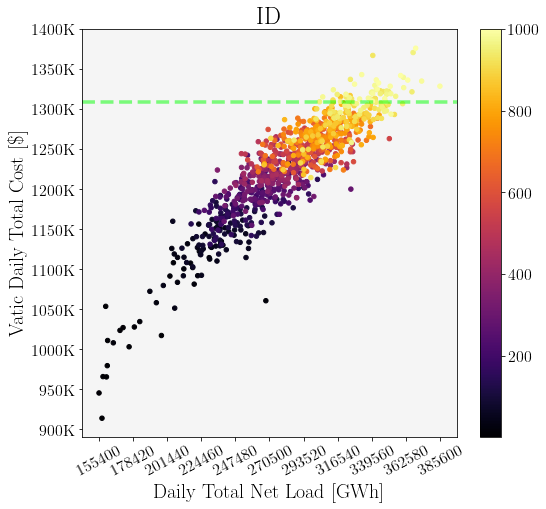

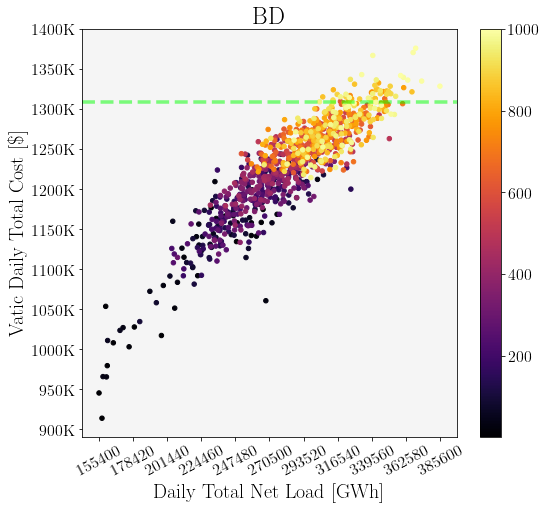

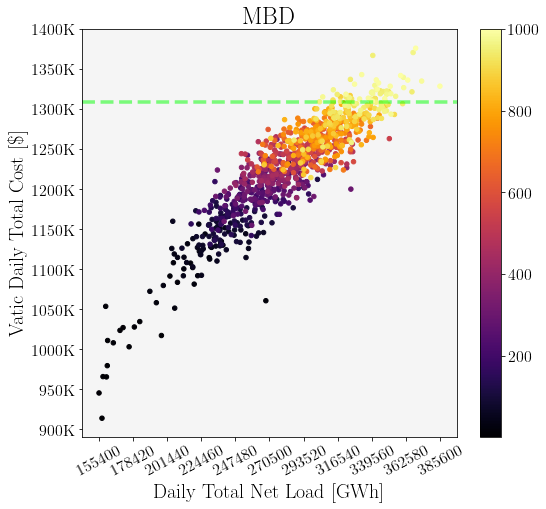

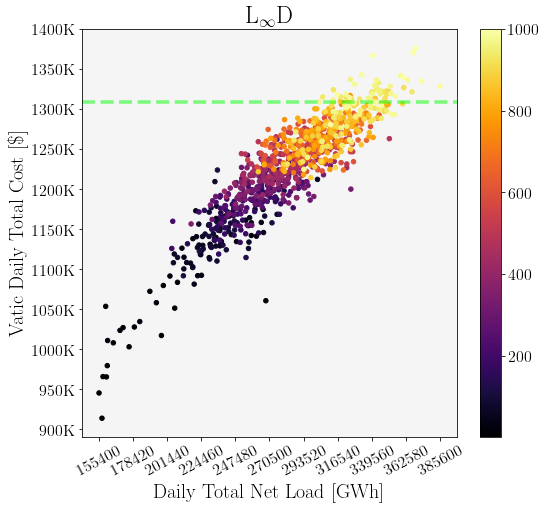

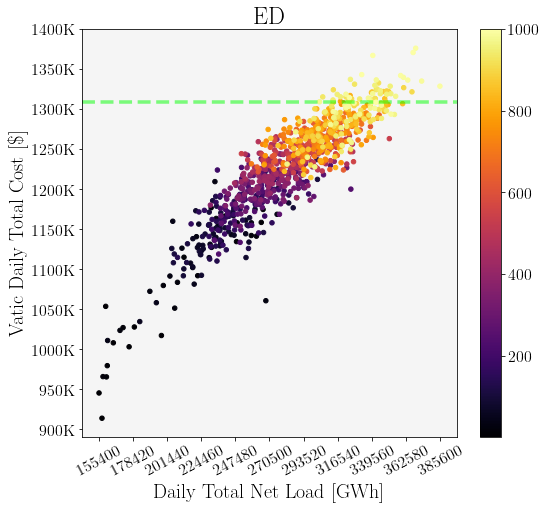

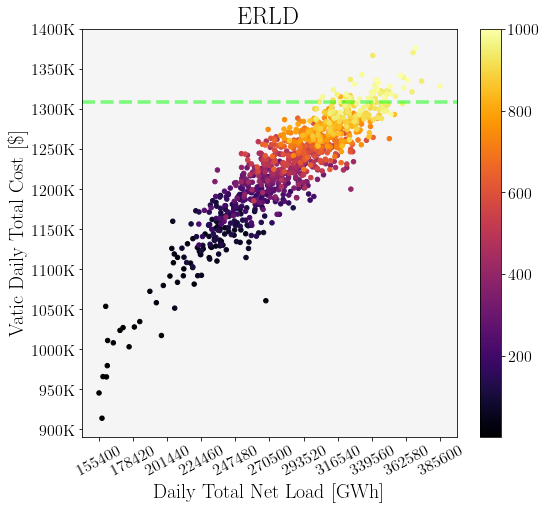

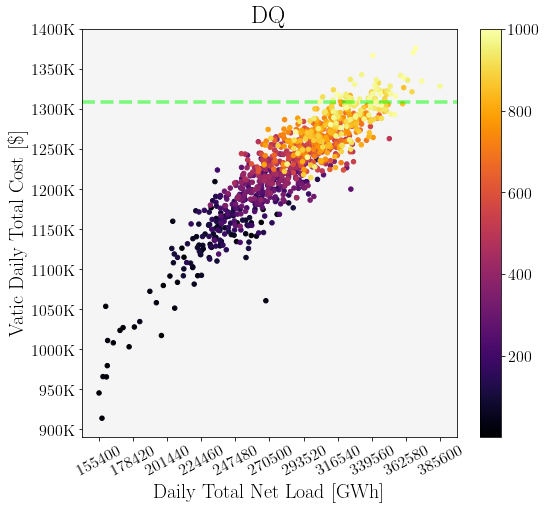

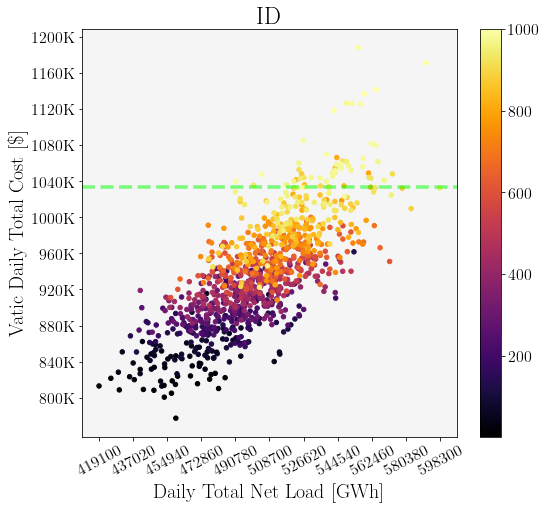

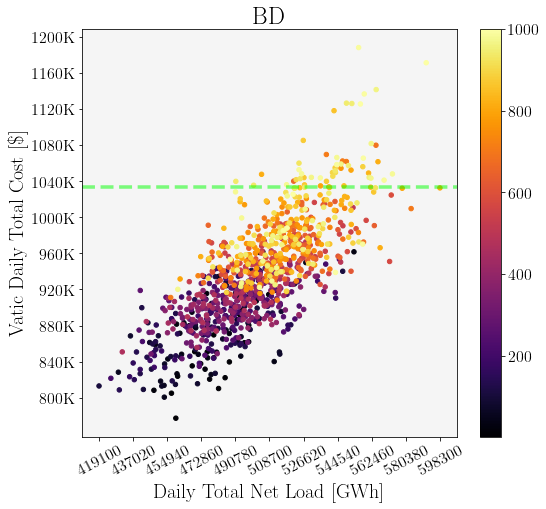

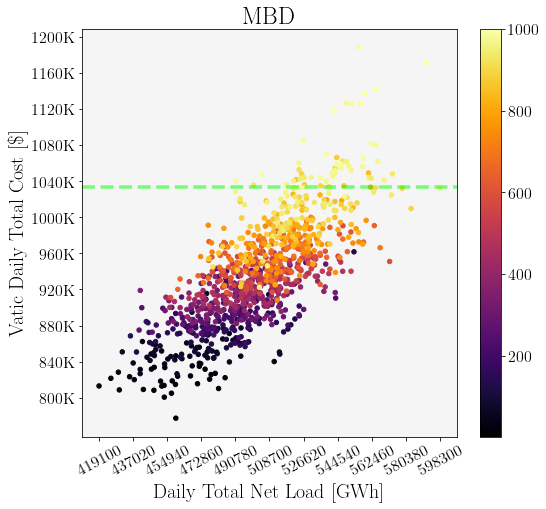

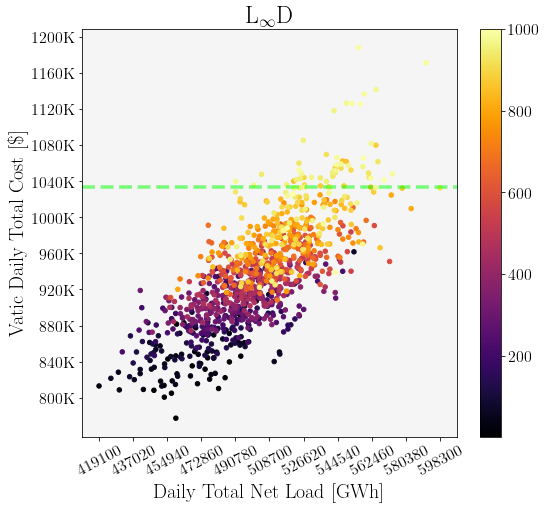

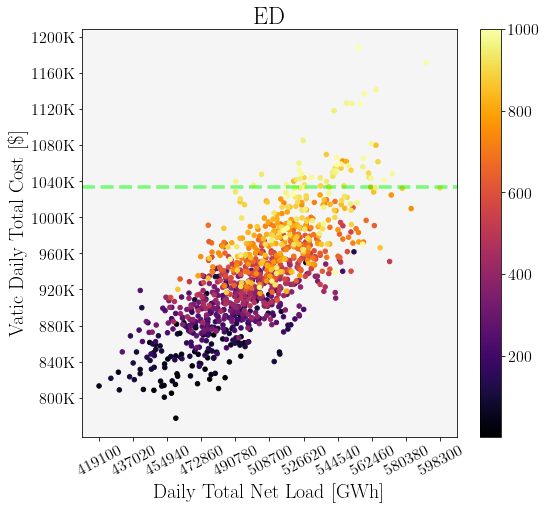

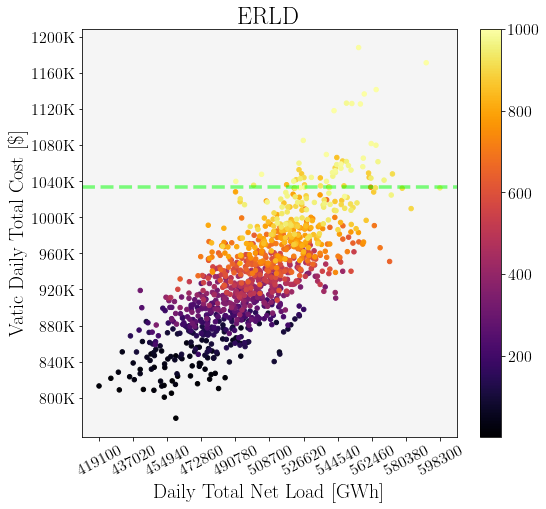

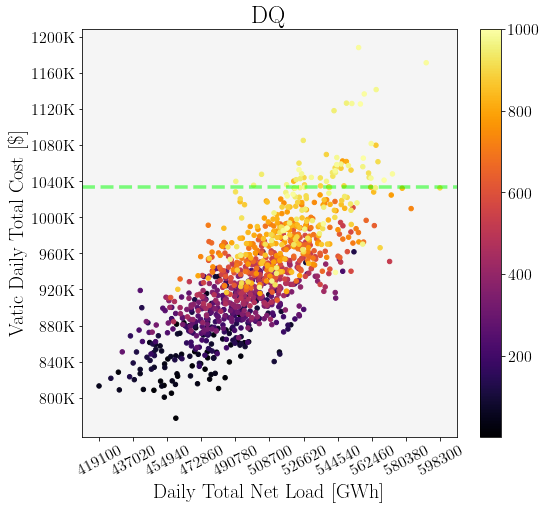

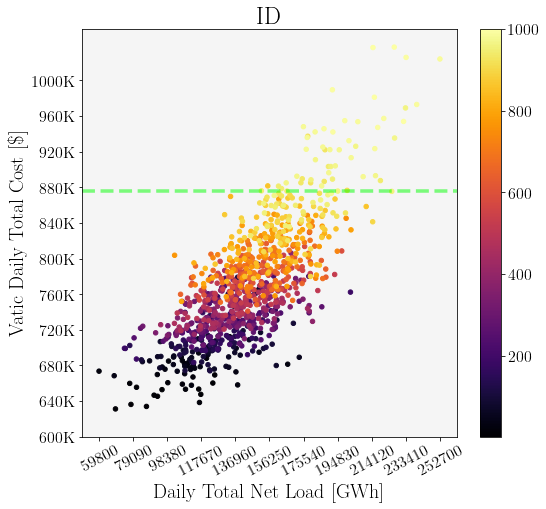

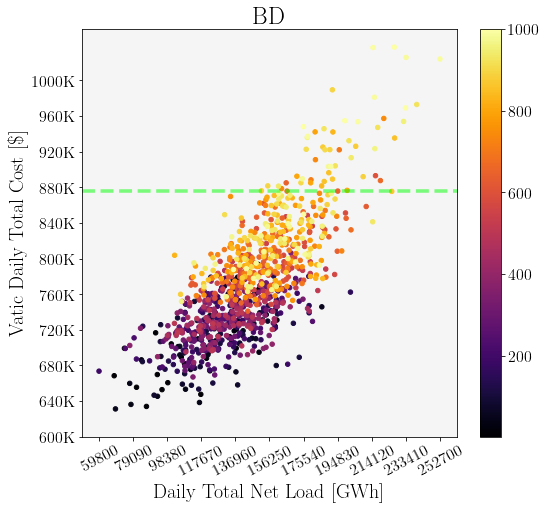

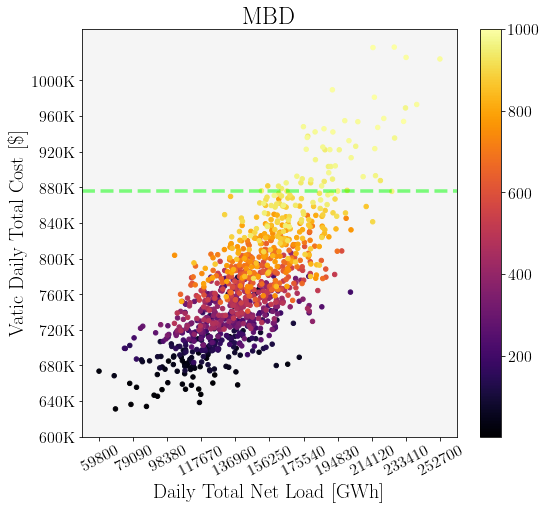

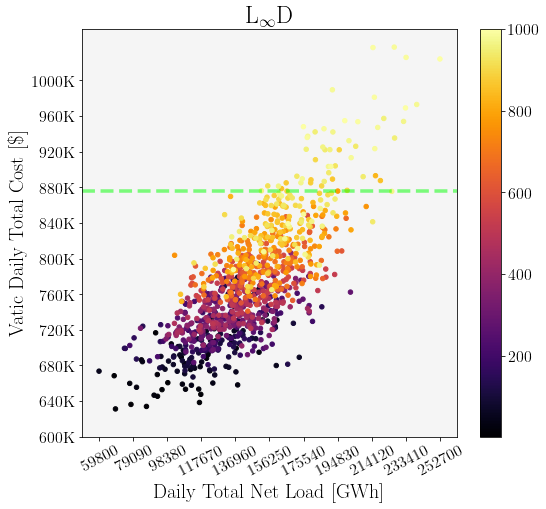

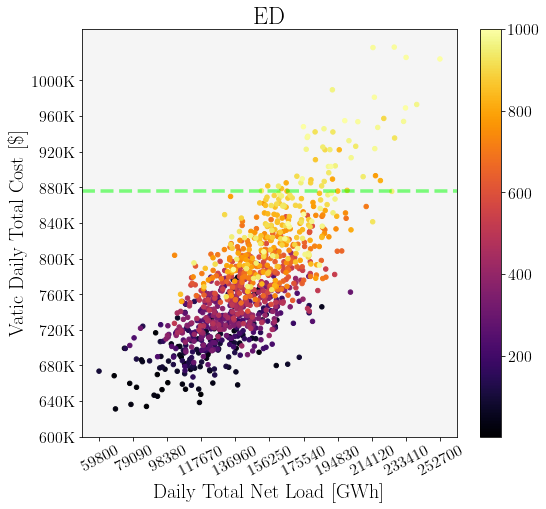

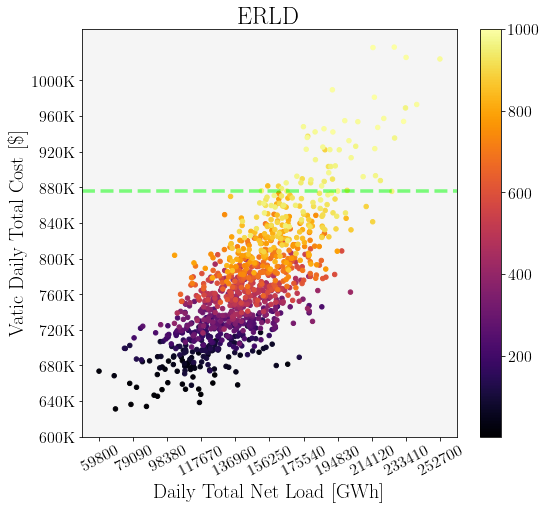

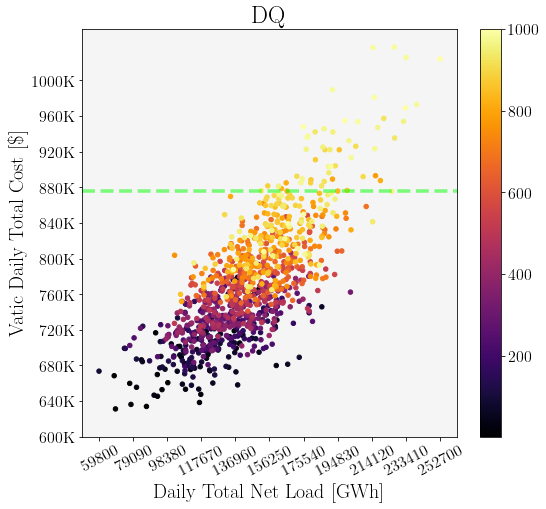

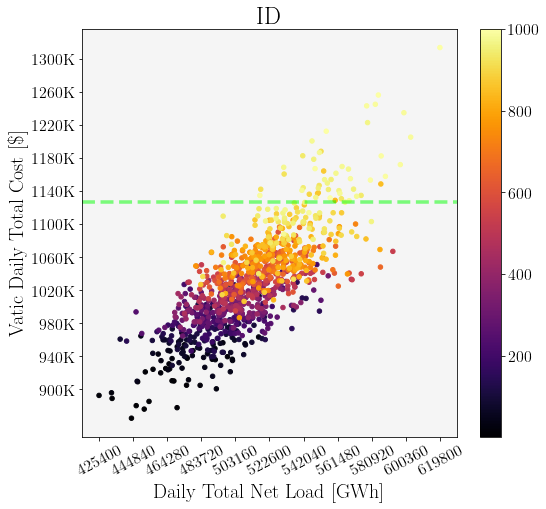

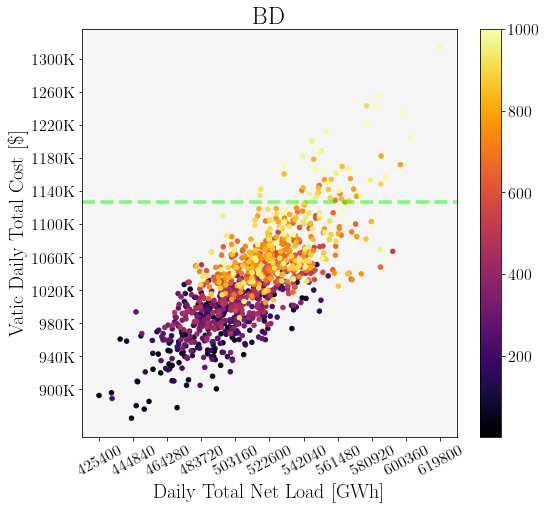

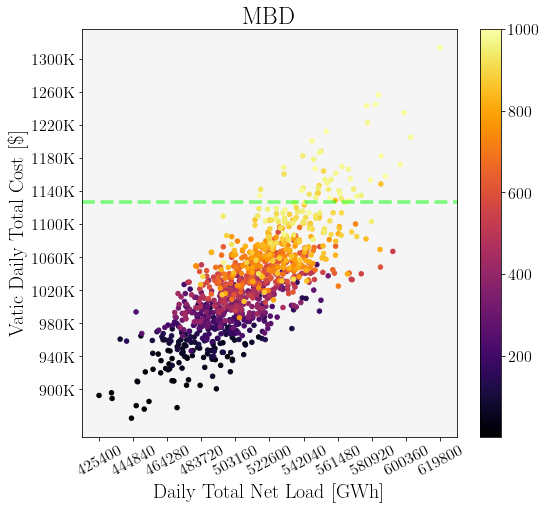

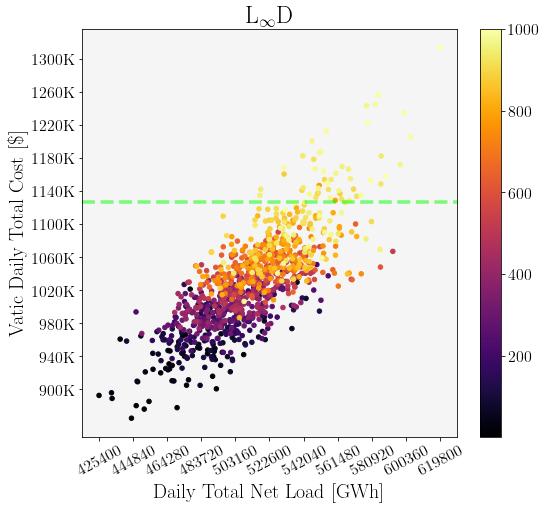

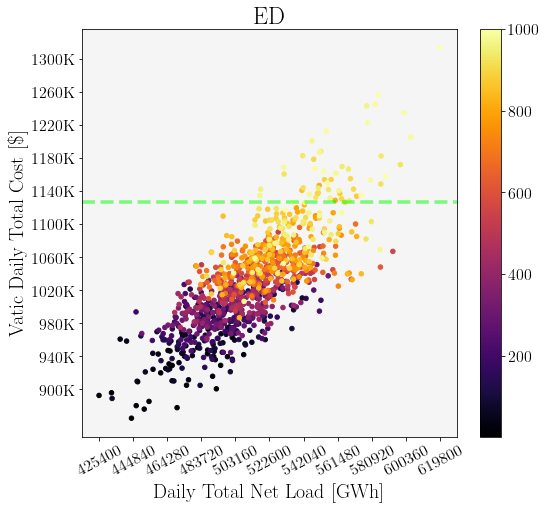

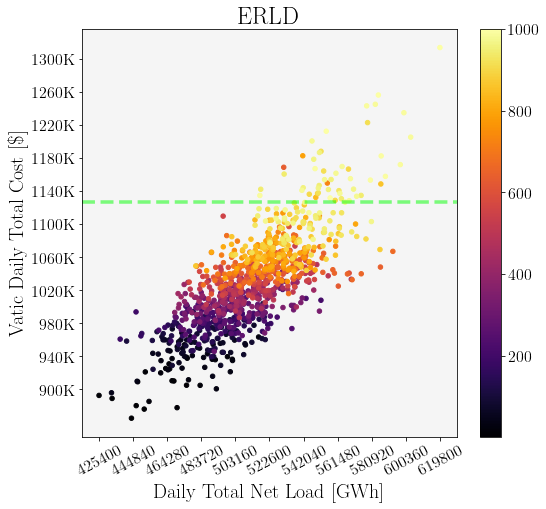

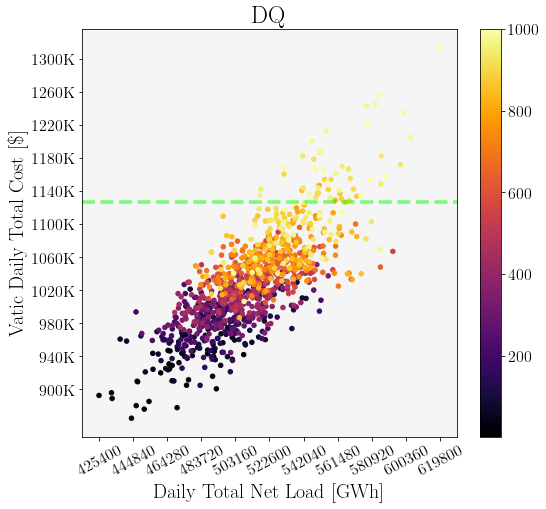

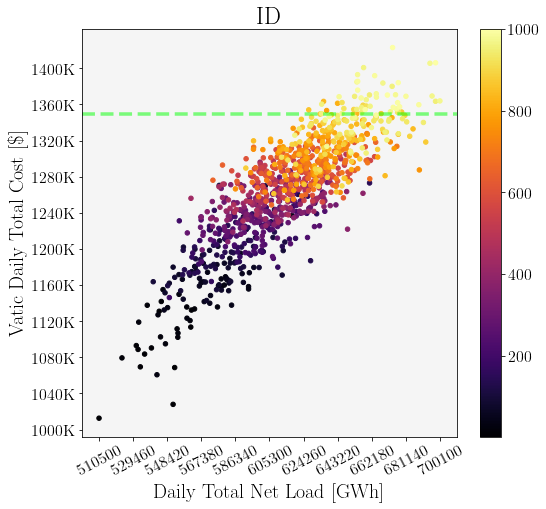

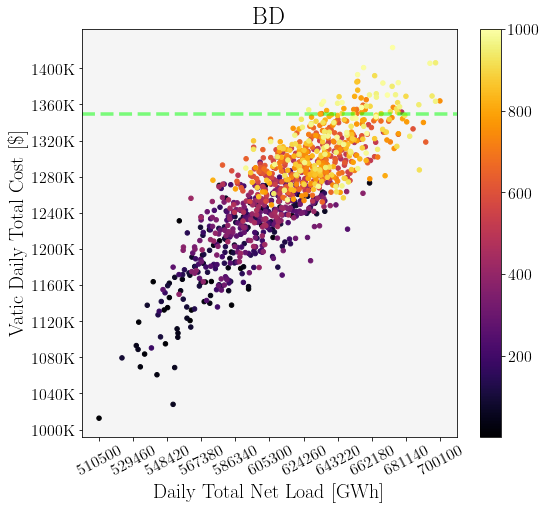

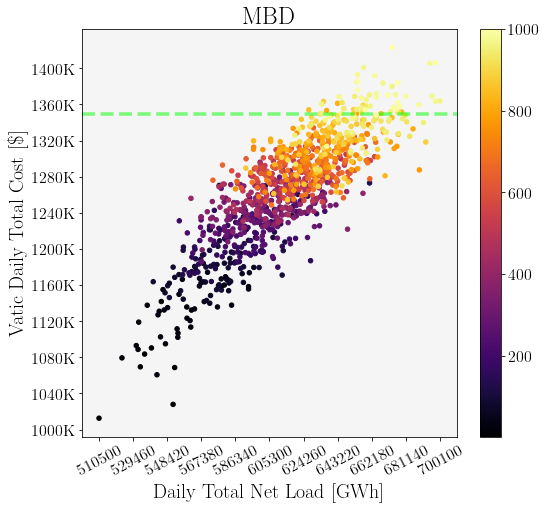

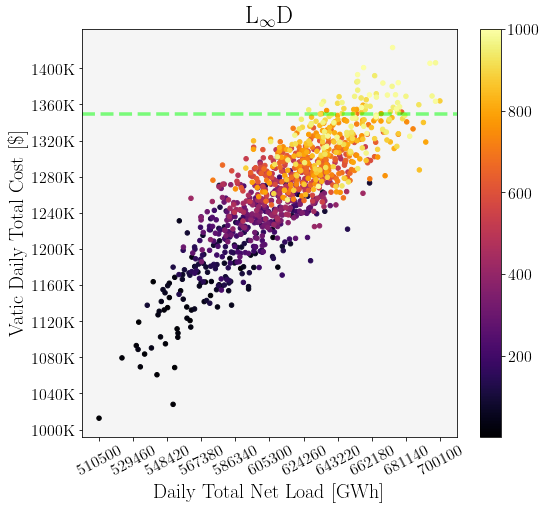

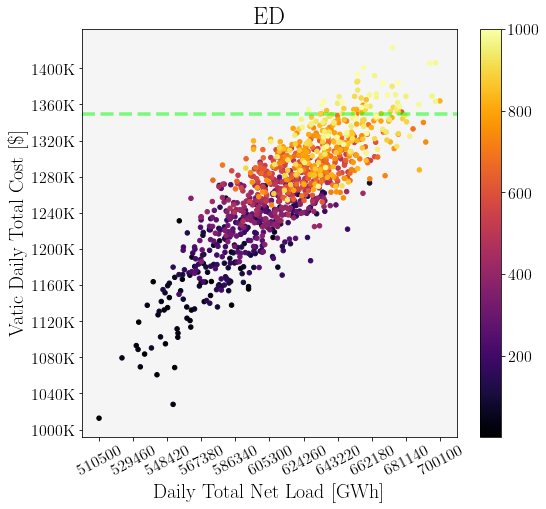

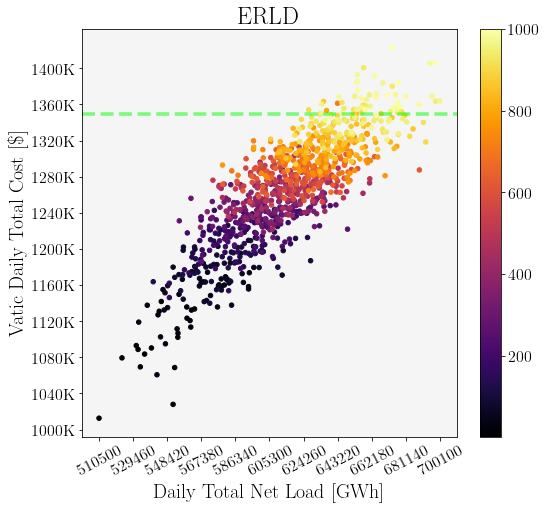

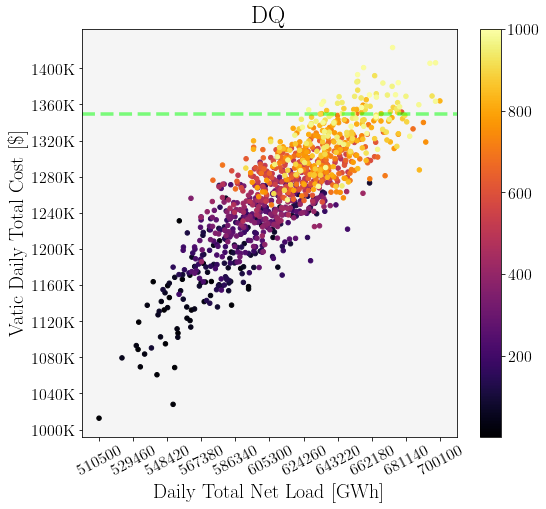

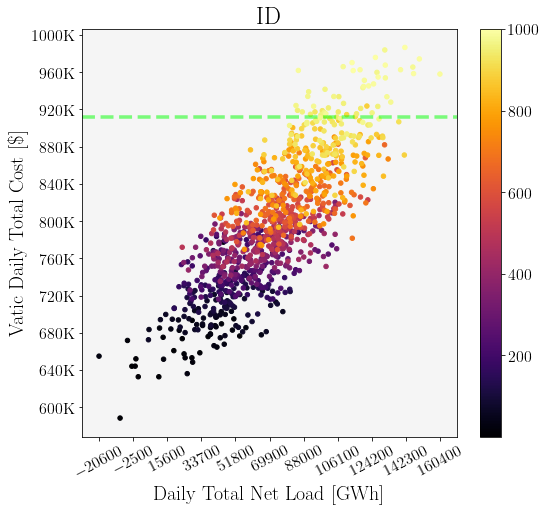

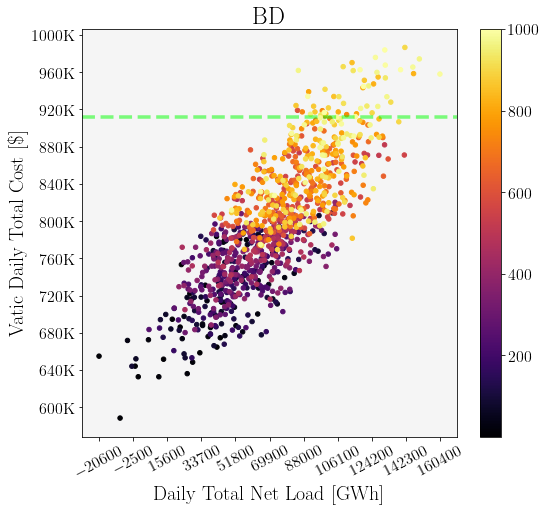

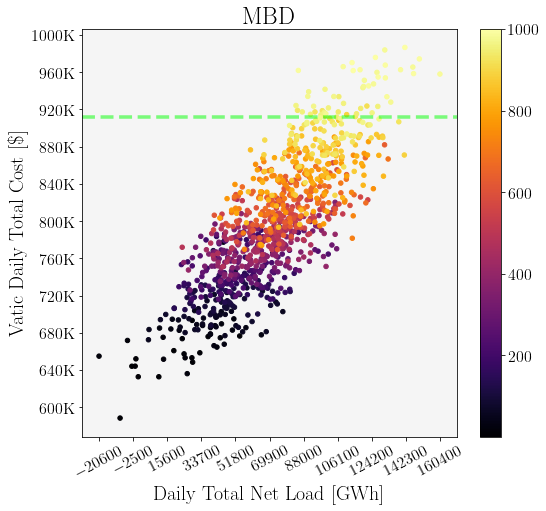

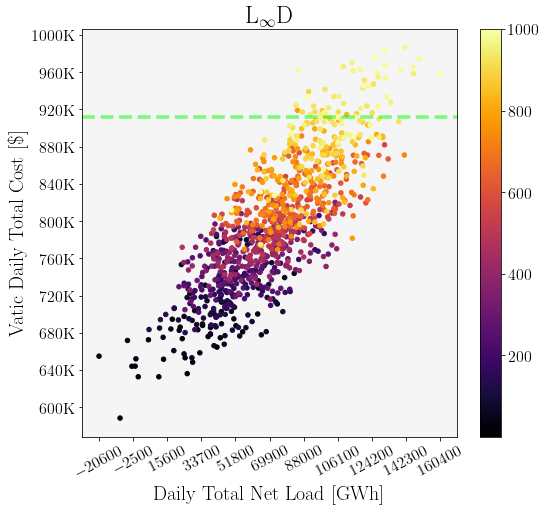

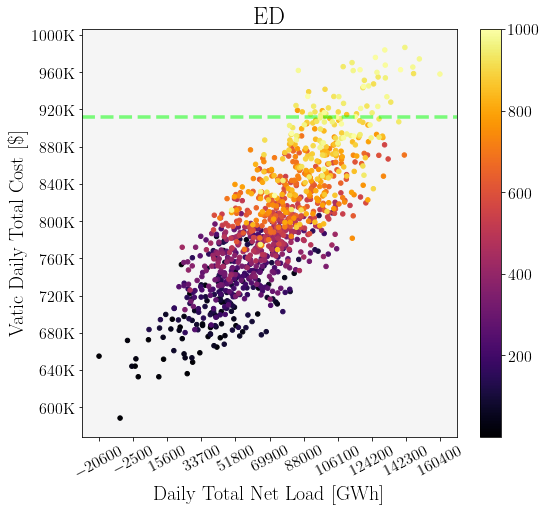

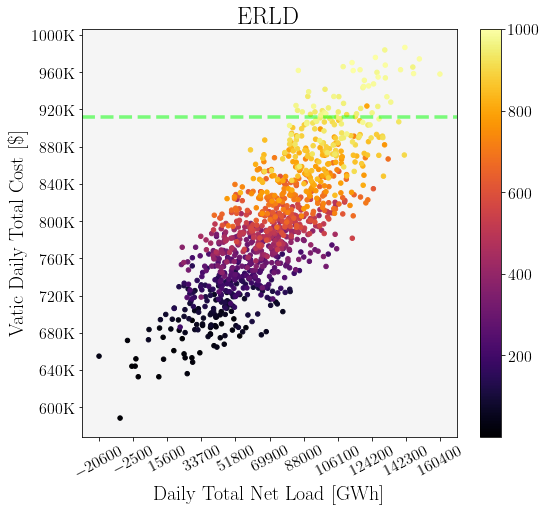

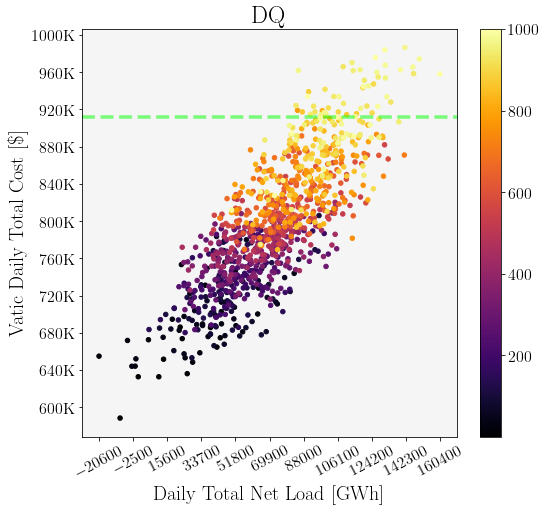

In [13]:
def _score(S_, S_hat_):
    S_correct_ = np.intersect1d(S_, S_hat_)
    return len(S_correct_)


def _deepest(Y_sc_, id_rank_):
    
    a_mu  = np.sum(np.mean(Y_sc_, axis = 1))
    a_sc_ = np.sum(Y_sc_, axis = 0)
    
    j = 0
    k = 0
    id_rank_prime_ = np.zeros(id_rank_.shape)
    
    N_scenarios = id_rank_.shape[0]
    
    for i in id_rank_:

        if a_sc_[i] > a_mu:
            id_rank_prime_[j] = i
            j += 1
        else:
            id_rank_prime_[N_scenarios - k - 1] = i
            k += 1
            
    return id_rank_prime_.astype(int)

def _select_extreme_samples(X_0_, X_1_, X_2_, X_3_, N_scenarios, Q_scenarios, P_scenarios, F_scenarios):
    
    # Empirical Density Function
    def __EDF(y_):
        n = y_.shape[0]
        z_ = np.zeros((n,))
        for j in range(n,):
            z_[j] = (y_ < y_[j]).sum()
        return z_/n
    
    
    F_scenarios = S_scenarios
    rate        = F_scenarios/100.
    
    if F_scenarios > 100.:
        P_scenarios = int(P_scenarios*rate) 
        Q_scenarios = int(Q_scenarios*rate) 
        N_scenarios = int(N_scenarios*rate) 

    X_4_ = X_1_ + X_2_
    idx_ = np.linspace(0, X_0_.shape[-1] - 1, X_0_.shape[-1], dtype = int)

    x_0_score_, x_0_rank_ = _MBD(X_0_)
    x_1_score_, x_1_rank_ = _MBD(X_1_)
    x_2_score_, x_2_rank_ = _MBD(X_2_)
        
    x_0_rank_ = np.argsort(x_0_score_)
    x_0_rank_ = _deepest(X_0_, x_0_rank_)
    i_sel_    = x_0_rank_[:N_scenarios]
    
    idx_prime_ = idx_[i_sel_]
    
    X_0_sel_ = X_0_[:, i_sel_]
    X_1_sel_ = X_1_[:, i_sel_]
    X_2_sel_ = X_2_[:, i_sel_]
    X_3_sel_ = X_3_[:, i_sel_]
    X_4_sel_ = X_4_[:, i_sel_]
    
    x_0_score_, x_0_rank_ = _MBD(X_0_sel_)
    x_1_score_, x_1_rank_ = _MBD(X_1_sel_)
    x_2_score_, x_2_rank_ = _MBD(X_2_sel_)
    x_3_score_, x_3_rank_ = _MBD(X_3_sel_)
    x_4_score_, x_4_rank_ = _MBD(X_4_sel_)

    x_prime_rank_ = np.argsort(x_1_score_ * x_2_score_)
    x_prime_rank_ = _deepest(X_0_sel_, x_prime_rank_)
    i_sel_        = x_prime_rank_[:Q_scenarios]
    
    idx_prime_prime_ = idx_prime_[i_sel_]

    X_0_sel_ = X_0_sel_[:, i_sel_]
        
    #area_  = np.sum(X_0_sel_, axis = 0)
    area_ = np.sum(X_0_sel_.T > np.repeat(np.mean(X_0_sel_.T, axis = 0)[np.newaxis, :], X_0_sel_.shape[1], axis = 0), axis = 1)

    x_prime_rank_ = np.argsort(__EDF(area_))[::-1]
    i_sel_        = x_prime_rank_[:P_scenarios]

    idx_prime_prime_prime_ = idx_prime_prime_[i_sel_]

    X_0_sel_ = X_0_sel_[:, i_sel_]
    
    area_  = np.sum(X_0_sel_, axis = 0)
    #area_ = np.sum(X_0_sel_.T > np.repeat(np.mean(X_0_sel_.T, axis = 0)[np.newaxis, :], X_0_sel_.shape[1], axis = 0), axis = 1)

    x_prime_rank_ = np.argsort(__EDF(area_))[::-1]
    #i_sel_        = x_prime_rank_[:100]

    idx_prime_prime_prime_prime_ = idx_prime_prime_prime_[x_prime_rank_][:F_scenarios]
    
    return idx_prime_, idx_prime_prime_, idx_prime_prime_prime_, idx_prime_prime_prime_prime_

def _scatter_plot_extreme_metrics(X_, y_, idx_x_, idx_y_, title, name, path, save = False):
    

    x_     = np.sum(X_, axis = 0)
    y_     = y_ /1000.
    thr_50 = y_[idx_y_][::-1][N_extreme]

    z_ = plt.cm.inferno(np.linspace(0, 1., N_scenarios))

    plt.figure(figsize = (8.4, 7.5))
    plt.title(title, fontsize = 24)
        
    plt.scatter(x_[idx_x_], y_[idx_x_], alpha = 1., 
                                        s     = 20., 
                                        c     = z_)
    
    plt.axhline(y = thr_50, color     = 'lime', 
                            linestyle = '--', 
                            linewidth = 3.5, 
                            alpha     = 0.5)

    plt.ylabel('Vatic Daily Total Cost [\$]', fontsize = 20)
    plt.xlabel('Daily Total Net Load [GWh]', fontsize = 20)

    y_low    = np.around(y_.min()/100.)*100.
    y_high   = np.around(y_.max()/100.)*100.
    y_ticks_ = np.linspace(y_low, y_high, 11)
    y_label_ = [r'{}K'.format(int(y_tick)) for y_tick in y_ticks_]        
    plt.yticks(y_ticks_, y_label_, fontsize = 16)

    x_low    = np.around(x_.min()/100.)*100.
    x_high   = np.around(x_.max()/100.)*100.
    x_ticks_ = np.linspace(x_low, x_high, 11)
    plt.xticks(x_ticks_, rotation = 27.5, fontsize = 16)
    
    plt.colorbar(plt.cm.ScalarMappable(cmap = 'inferno', 
                                       norm = plt.Normalize(vmin = 1, vmax = N_scenarios))).ax.tick_params(labelsize = 16)

    if save: plt.savefig(path + name)
    else:    plt.show()
        
        
N_extreme   = 50
S_scenarios = 100
N_days      = L_.shape[-1]
N_scenarios = L_.shape[0]

scores_    = np.zeros((2, N_days, 7))

y_label_ = ['Jul. 09', 'Jun. 04', 'May. 27', 'Dec. 19', 'Feb16', 'Nov. 20', 'Sep. 4', 'Jan. 20']


for i_day in range(N_days):
    
    X_0_ = L_[..., i_day].T 
    X_1_ = S_[..., i_day].T 
    X_2_ = W_[..., i_day].T 
    X_3_ = N_[..., i_day].T 
    X_4_ = X_1_ + X_2_

    Y_0_ = Y_[:, 0, i_day]
    Y_1_ = Y_[:, 1, i_day]
    Y_2_ = Y_[:, 2, i_day]
    Y_3_ = Y_[:, 3, i_day]

    #idx_s_ = np.argsort(Y_1_)[::-1]
    #N_s    = np.sum(Y_1_ > 0.)
    #idx_c_ = np.argsort(Y_3_)[::-1]

    idx_e_0_, idx_e_1_, idx_e_2_, idx_e_3_ = _select_extreme_samples(X_0_, X_1_, X_2_, X_3_, N_scenarios = 175, Q_scenarios = 150, P_scenarios = 125, F_scenarios = S_scenarios)

    idx_c_ = np.argsort(Y_0_)
    print(i_day, y_label_[i_day], _score(idx_c_[-S_scenarios:], idx_e_3_))
        
    x_0_score_, x_0_rank_ = _ID(X_0_)
    idx_id_               = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 0]  = _score(idx_c_[-S_scenarios:], idx_id_[-S_scenarios:])
    scores_[1, i_day, 0]  = _score(idx_e_3_[-S_scenarios:], idx_id_[-S_scenarios:])    
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_id_, idx_c_, r'ID', r"DN-ID-{}.pdf".format(i_day), path_to_images, save = True)

    x_0_score_, x_0_rank_ = _BD(X_0_)
    idx_bd_               = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 1]  = _score(idx_c_[-S_scenarios:], idx_bd_[-S_scenarios:])
    scores_[1, i_day, 1]  = _score(idx_e_3_[-S_scenarios:], idx_bd_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_bd_, idx_c_, r'BD', r"DN-BD-{}.pdf".format(i_day), path_to_images, save = True)

    x_0_score_, x_0_rank_ = _MBD(X_0_)
    idx_mbd_              = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 2]  = _score(idx_c_[-S_scenarios:], idx_mbd_[-S_scenarios:])
    scores_[1, i_day, 2]  = _score(idx_e_3_[-S_scenarios:], idx_mbd_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_mbd_, idx_c_, r'MBD', r"DN-MBD-{}.pdf".format(i_day), path_to_images, save = True)

    x_0_score_, x_0_rank_ = _LinfD(X_0_)
    idx_ld_               = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 3]  = _score(idx_c_[-S_scenarios:], idx_ld_[-S_scenarios:])
    scores_[1, i_day, 3]  = _score(idx_e_3_[-S_scenarios:], idx_ld_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_ld_, idx_c_, r'L$_{\infty}$D', r"DN-LD-{}.pdf".format(i_day), path_to_images, save = True)


    x_0_score_, x_0_rank_ = _ED(X_0_)
    idx_ed_               = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 4]  = _score(idx_c_[-S_scenarios:], idx_ed_[-S_scenarios:])
    scores_[1, i_day, 4]  = _score(idx_e_3_[-S_scenarios:], idx_ed_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_ed_, idx_c_, r'ED', r"DN-ED-{}.pdf".format(i_day), path_to_images, save = True)


    x_0_score_, idx_elrd_ = _ERLD(X_0_, method = 'small one-sided test')
    scores_[0, i_day, 5]  = _score(idx_c_[-S_scenarios:], idx_elrd_[-S_scenarios:])
    scores_[1, i_day, 5]  = _score(idx_e_3_[-S_scenarios:], idx_elrd_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_elrd_, idx_c_, r'ERLD', r"DN-ERLD-{}.pdf".format(i_day), path_to_images, save = True)


    x_0_score_, x_0_rank_ = _DQ(X_0_)
    idx_dq_               = _deepest(X_0_, x_0_rank_)[::-1]
    scores_[0, i_day, 6]  = _score(idx_c_[-S_scenarios:], idx_dq_[-S_scenarios:])
    scores_[1, i_day, 6]  = _score(idx_e_3_[-S_scenarios:], idx_dq_[-S_scenarios:])
    _scatter_plot_extreme_metrics(X_3_, Y_0_, idx_dq_, idx_c_, r'DQ', r"DN-DQ-{}.pdf".format(i_day), path_to_images, save = True)

In [ ]:
print(scores_)
print(scores_.shape)

name  = r"DN-Table.pdf"
title = r"Consistent Samples with Proposed Method"
path  = path_to_images
save  = True

idx_     = [7, 4, 2, 1, 0, 6, 5, 3]
y_label_ = ['Jul. 09', 'Jun. 04', 'May. 27', 'Dec. 19', 'Feb16', 'Nov. 20', 'Sep. 4', 'Jan. 20']
x_label_ = ['ID', 'BD', 'MBD', 'L$_{\infty}$D', 'ED', 'ERLD', 'DQ']

S_prime_ = scores_[1, ...].copy()

S_prime_ = S_prime_[idx_, :]
y_label_ = [y_label_[i] for i in idx_]
y_label_ = y_label_ + ['Avg.', 'Median']
S_prime_ = np.concatenate((S_prime_, np.mean(S_prime_, axis = 0)[np.newaxis, :], np.median(S_prime_, axis = 0)[np.newaxis, :]), axis = 0)
print(S_prime_)

plt.figure(figsize = (8.4, 7.5))
plt.title(title, fontsize = 24)
plt.imshow(S_prime_, cmap = 'inferno', vmin = 0, vmax = 100)

for i in range(S_prime_.shape[0]):
    for j in range(S_prime_.shape[1]):
        if (i == 8) & (j == 2): plt.text(x = j, y = i, s = np.around(S_prime_[i, j], 1), va = 'center', ha = 'center', size = 20, color = 'red')
        elif (i == 9) & (j == 5): plt.text(x = j, y = i, s = np.around(S_prime_[i, j], 1), va = 'center', ha = 'center', size = 20, color = 'blue')
        elif i > 7: plt.text(x = j, y = i, s = np.around(S_prime_[i, j], 1), va = 'center', ha = 'center', size = 20, color = 'black')
        elif i < 8: plt.text(x = j, y = i, s = int(S_prime_[i, j]), va = 'center', ha = 'center', size = 20, color = 'k')


plt.axhline(y = 7.5, color = 'k', linewidth = 2.5)
plt.axhline(y = 8.5, color = 'k', linewidth = 2.5)

plt.ylabel('Date', fontsize = 20)
plt.xlabel('Depth Notion', fontsize = 20)

x_ticks_ = np.linspace(0, 6, 7)
y_ticks_ = np.linspace(0, 9, 10)

plt.xticks(x_ticks_, x_label_, rotation = 27.5, fontsize = 16)
plt.yticks(y_ticks_, y_label_, fontsize = 16)

plt.colorbar(plt.cm.ScalarMappable(cmap = 'inferno', 
                                   norm = plt.Normalize(vmin = 0, vmax = 100))).ax.tick_params(labelsize = 14)
    
if save: plt.savefig(path + name)
else:    plt.show()

In [ ]:
def _plot_pipeline(X_, Z_, Y_, sel_, title, name, path, N_extreme = 50, save = False):
    
    N_hours, N_scenarios = X_.shape
    
    x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
    z_ = plt.cm.Reds(np.linspace(0, 1., N_extreme))

    x_prime_    = x_ + 1
    rank_       = np.argsort(Y_[sel_])
    rank_prime_ = rank_[-N_extreme:]
    
    plt.figure(figsize = (8., 5.25))
    plt.title(title, fontsize = 24)
    plt.plot(x_, Z_, c = 'k', linewidth = 1.)

    for idx in sel_:
        plt.plot(x_, X_[:, idx], c = 'gold', linewidth = .5)
    
    for idx, i in zip(rank_prime_, range(N_extreme)):
        plt.plot(x_, X_[:, sel_][:, idx], '--', color = z_[i, :], linewidth = .75)

    y_low  = np.around(X_.min()/10000.)*10000.
    y_high = np.around(X_.max()/10000.)*10000.
    plt.yticks(np.linspace(y_low, y_high, 11), fontsize = 16)
    plt.xticks(x_[::2], x_prime_[::2], fontsize = 16)
    plt.grid()
    plt.ylabel('Energy [GWh]', fontsize = 20)
    plt.xlabel('Time [hour]', fontsize = 20)
    plt.xlim([0, 23])
    plt.colorbar(plt.cm.ScalarMappable(cmap = 'Reds', norm = plt.Normalize(vmin = 1, vmax = N_extreme))).ax.tick_params(labelsize = 16)

    if save: plt.savefig(path + name)
    else:    plt.show()
    
    
def _plot_ranking(X_, sel_, title, name, path, save = False):
    
    plt.rcParams['axes.facecolor'] = 'whitesmoke'

    N_hours, N_scenarios = X_.shape
    
    x_ = np.linspace(0, N_hours - 1, N_hours, dtype = int)
    z_ = plt.cm.inferno(np.linspace(0, 1., sel_.shape[0]))
    
    x_prime_ = x_ + 1
    
    plt.figure(figsize = (8, 5.25))
    plt.title(title, fontsize = 24)
    plt.plot(x_, X_, c = 'gray', linewidth = .25)
    
    for idx, i in zip(sel_, range(sel_.shape[0])):
        plt.plot(x_, X_[:, idx], color = z_[i, :], linewidth = .75)

    y_low  = np.around(X_.min()/10000.)*10000.
    y_high = np.around(X_.max()/10000.)*10000.
    
    plt.yticks(np.linspace(y_low, y_high, 11), fontsize = 16)
    plt.xticks(x_[::2], x_prime_[::2], fontsize = 16)
    plt.grid()
    plt.ylabel('Energy [GWh]', fontsize = 20)
    plt.xlabel('Time [hour]', fontsize = 20)
    plt.xlim([0, 23])
    plt.colorbar(plt.cm.ScalarMappable(cmap = 'inferno', norm = plt.Normalize(vmin = 1, vmax = sel_.shape[0]))).ax.tick_params(labelsize = 16)

    if save: plt.savefig(path + name)
    else:    plt.show()
        
def _scatter_plot_extreme_samples(X_, y_, idx_x_, idx_y_, title, name, path, save = False):
    
    plt.rcParams['axes.facecolor'] = 'whitesmoke'

    x_ = np.sum(X_, axis = 0)
    y_ = y_ /1000.
    thr_50  = y_[idx_y_][::-1][50]
    thr_100 = y_[idx_y_][::-1][100]
    thr_150 = y_[idx_y_][::-1][150]
    thr_200 = y_[idx_y_][::-1][200]

    idx_x_ = idx_x_[::-1]
    print(idx_x_.shape, idx_y_.shape)
    
    z_ = plt.cm.inferno(np.linspace(0, 1., idx_x_.shape[0]))

    plt.figure(figsize = (8.4, 7.5))
    #plt.title(title, fontsize = 24)
    plt.scatter(x_, y_, c = 'gray', alpha = 1., s = 20.)
    
    plt.scatter(x_[idx_x_], y_[idx_x_], s = 20.5, c = z_)

    plt.axhline(y = thr_50, color = 'lime', linestyle = '--', linewidth = 3.5, alpha = 0.5)

    plt.ylabel('Vatic Daily Total Cost [\$]', fontsize = 20)
    plt.xlabel('Daily Total Net Load [GWh]', fontsize = 20)
    
    y_low    =  np.around(y_.min()/100.)*100.
    y_high   = np.around(y_.max()/100.)*100.
    y_ticks_ = np.linspace(y_low, y_high, 11)
    y_label_ = [r'{}K'.format(int(y_tick)) for y_tick in y_ticks_]        
    plt.yticks(y_ticks_, y_label_, fontsize = 16)
    
    x_low    =  np.around(x_.min()/100.)*100.
    x_high   = np.around(x_.max()/100.)*100.
    x_ticks_ = np.linspace(x_low, x_high, 11)
    plt.xticks(x_ticks_, rotation = 27.5, fontsize = 16)
    
    #plt.grid()
    plt.colorbar(plt.cm.ScalarMappable(cmap = 'inferno', norm = plt.Normalize(vmin = 1, vmax = idx_x_.shape[0]))).ax.tick_params(labelsize = 16)

    if save: plt.savefig(path + name)
    else:    plt.show()


N_extreme   = 50
S_scenarios = 100
i_day       = 3

X_0_ = L_[..., i_day].T 
X_1_ = S_[..., i_day].T 
X_2_ = W_[..., i_day].T 
X_3_ = N_[..., i_day].T 
X_4_ = X_1_ + X_2_

Y_0_ = Y_[:, 0, i_day]
Y_1_ = Y_[:, 1, i_day]
Y_2_ = Y_[:, 2, i_day]
Y_3_ = Y_[:, 3, i_day]

#idx_s_ = np.argsort(Y_1_)[::-1]
#N_s    = np.sum(Y_1_ > 0.)
#idx_c_ = np.argsort(Y_3_)[::-1]
idx_c_ = np.argsort(Y_0_)

idx_e_0_, idx_e_1_, idx_e_2_, idx_e_3_ = _select_extreme_samples(X_0_, X_1_, X_2_, X_3_, N_scenarios = 175, Q_scenarios = 150, P_scenarios = 125, F_scenarios = S_scenarios)
print(i_day, N_extreme, S_scenarios, _score(idx_c_[-N_extreme:], idx_e_3_))

_plot_pipeline(X_0_, X_0_, Y_0_, idx_e_0_, r'Load', r"step_1L-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)
_plot_pipeline(X_4_, X_4_, Y_0_, idx_e_0_, r'Solar \& Wind', r"step_1G-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)

_plot_pipeline(X_0_, X_0_[:, idx_e_0_], Y_0_, idx_e_1_, r'Load', r"step_2L-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)
_plot_pipeline(X_4_, X_4_[:, idx_e_0_], Y_0_, idx_e_1_, r'Solar \& Wind', r"step_2G-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)

_plot_pipeline(X_0_, X_0_[:, idx_e_1_], Y_0_, idx_e_2_, r'Load', r"step_3L-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)
_plot_pipeline(X_4_, X_4_[:, idx_e_1_], Y_0_, idx_e_2_, r'Solar \& Wind', r"step_3G-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)

_plot_pipeline(X_0_, X_0_[:, idx_e_2_], Y_0_, idx_e_3_, r'Load', r"step_4L-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)
_plot_pipeline(X_4_, X_4_[:, idx_e_2_], Y_0_, idx_e_3_, r'Solar \& Wind', r"step_4G-{}-{}.pdf".format(S_scenarios, i_day), path, N_extreme = 50, save = True)

# _plot_ranking(X_0_, idx_e_3_[::-1], r'Ranking Load Scenarios', r"LS-{}-{}.pdf".format(S_scenarios, i_day), path, save = True)
# _plot_ranking(X_4_, idx_e_3_[::-1], r'Ranking Solar \& Wind Scenarios', r"GS-{}-{}.pdf".format(S_scenarios, i_day), path, save = True)


#_scatter_plot_extreme_samples(X_3_, Y_0_, idx_e_0_, idx_c_, r"Top 50 Costly and 175 Selected Scenarios", r"SP-CL-{}-{}.pdf".format(S_scenarios, i_day), path)
#_scatter_plot_extreme_samples(X_3_, Y_0_, idx_e_1_, idx_c_, r"Top 50 Costly and 150 Selected Scenarios", r"SP-CL-{}-{}.pdf".format(S_scenarios, i_day), path)
#_scatter_plot_extreme_samples(X_3_, Y_0_, idx_e_2_, idx_c_, r"Top 50 Costly and 125 Selected Scenarios", r"SP-CL-{}-{}.pdf".format(S_scenarios, i_day), path)
#_scatter_plot_extreme_samples(X_3_, Y_0_, idx_e_3_, idx_c_, r"Top 50 Costly and Top 200 Extreme Scenarios", r"CN-{}-{}-{}.pdf".format(N_extreme, S_scenarios, i_day), path_to_images, save = True)

x_0_score_, x_0_rank_ = _MBD(X_0_)
idx_mbd_ = _deepest(X_0_, x_0_rank_)[:S_scenarios]
print(i_day, N_extreme, S_scenarios, _score(idx_c_[-N_extreme:], idx_mbd_))

x_1_score_, x_1_rank_ = _MBD(X_1_)
x_2_score_, x_2_rank_ = _MBD(X_2_)
idx_sw_ = np.argsort(x_1_score_ * x_2_score_)
idx_sw_ = _deepest(X_0_, idx_sw_)[:S_scenarios]
print(i_day, N_extreme, S_scenarios, _score(idx_c_[-N_extreme:], idx_sw_))

idx_h_ = np.argsort(np.sum(X_0_.T > np.repeat(np.mean(X_0_.T, axis = 0)[np.newaxis, :], X_0_.shape[1], axis = 0), axis = 1))[-S_scenarios:]
print(i_day, N_extreme, S_scenarios, _score(idx_c_[-N_extreme:], idx_h_))

idx_a_ = np.argsort(np.sum(X_0_, axis = 0))[-S_scenarios:]
print(i_day, N_extreme, S_scenarios, _score(idx_c_[-N_extreme:], idx_a_))

0
1


<ipython-input-278-cf693d090bb4>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


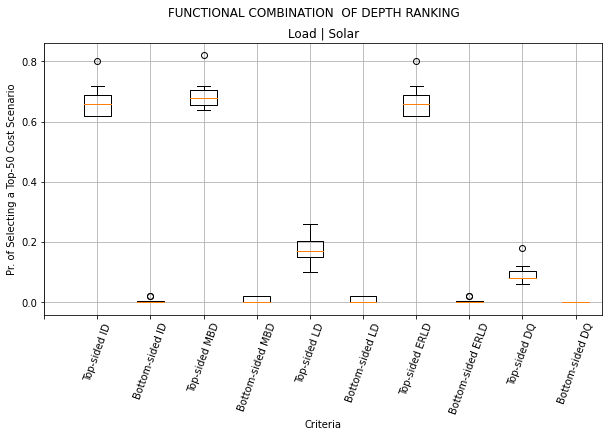

[0.6725 0.005  0.6925 0.0075 0.175  0.0075 0.6725 0.005  0.0975 0.    ] [0.66 0.   0.68 0.   0.17 0.   0.66 0.   0.08 0.  ]


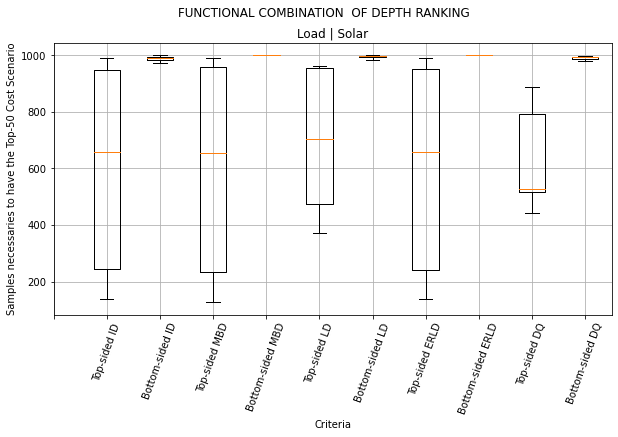

[ 598.375  988.5    593.25  1000.     700.75   995.5    598.5   1000.
  632.5    991.75 ] [ 659.   990.5  653.5 1000.   705.   998.   659.  1000.   529.   994.5]
2


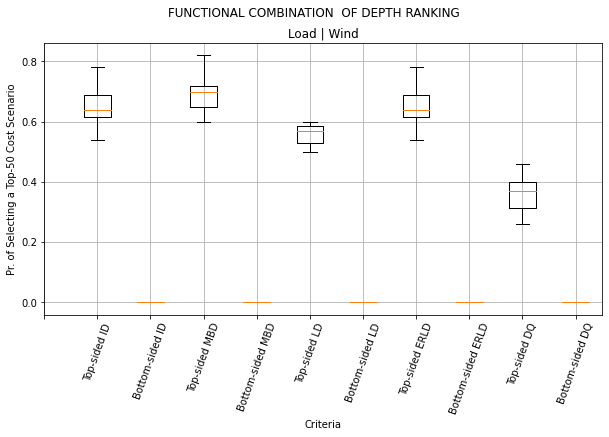

[0.6525 0.     0.6925 0.     0.5575 0.     0.6525 0.     0.36   0.    ] [0.64 0.   0.7  0.   0.57 0.   0.64 0.   0.37 0.  ]


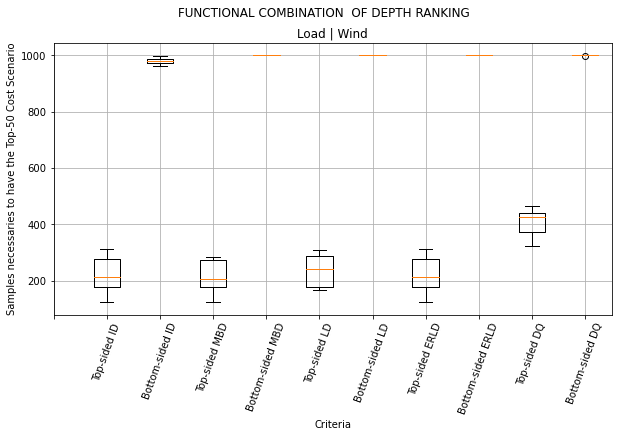

[ 222.375  981.125  214.875 1000.     236.375 1000.     222.375 1000.
  408.375  999.875] [ 214.   981.5  205.  1000.   240.  1000.   213.5 1000.   425.  1000. ]
3


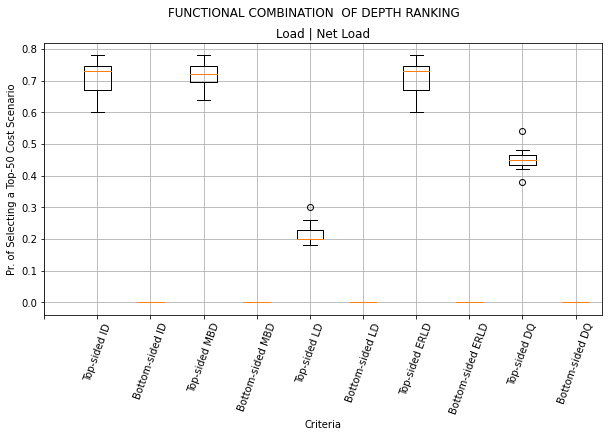

[0.7075 0.     0.7175 0.     0.22   0.     0.7075 0.     0.4525 0.    ] [0.73 0.   0.72 0.   0.2  0.   0.73 0.   0.45 0.  ]


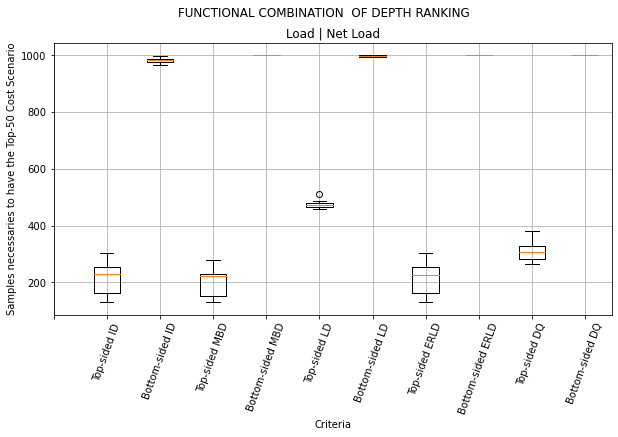

[ 217.125  982.     200.5   1000.     476.25   997.25   216.5   1000.
  312.625 1000.   ] [ 228.   982.5  222.  1000.   472.   997.5  227.  1000.   306.5 1000. ]
4


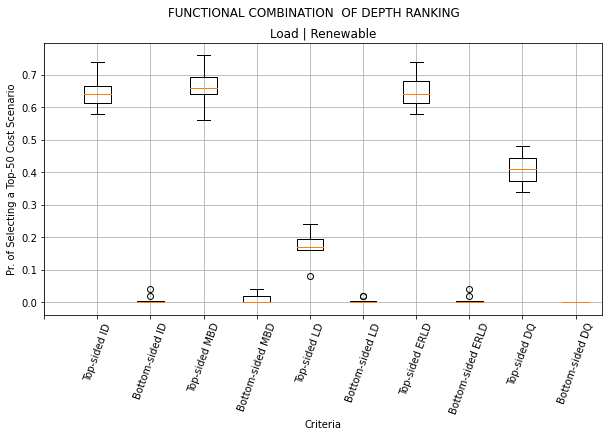

[0.65   0.0075 0.6675 0.01   0.175  0.005  0.6525 0.0075 0.41   0.    ] [0.64 0.   0.66 0.   0.17 0.   0.64 0.   0.41 0.  ]


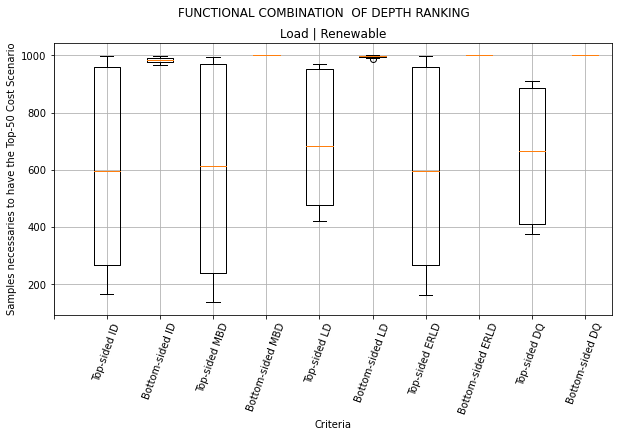

[ 597.625  983.     591.75  1000.     702.25   996.375  597.625 1000.
  651.75  1000.   ] [ 596.5  984.5  612.  1000.   682.   998.   597.5 1000.   667.  1000. ]
1
2


<ipython-input-278-cf693d090bb4>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


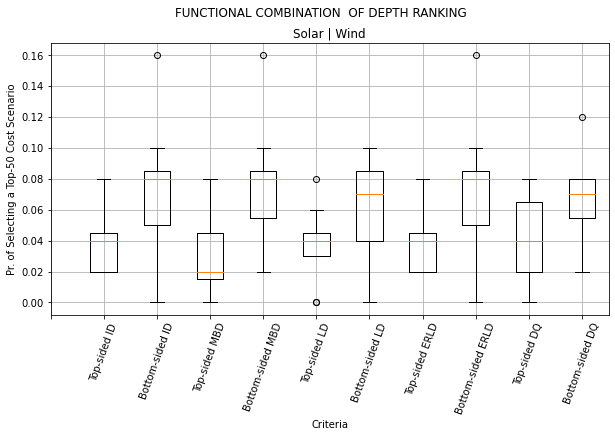

[0.04   0.0725 0.03   0.0775 0.0375 0.0625 0.04   0.0725 0.0425 0.0675] [0.04 0.08 0.02 0.08 0.04 0.07 0.04 0.08 0.04 0.07]


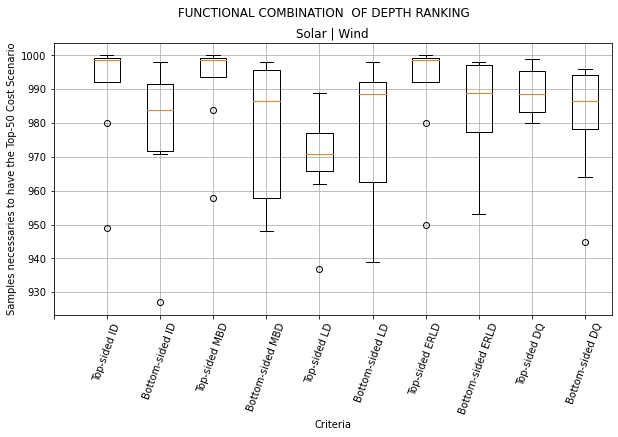

[990.125 977.75  991.875 977.75  968.875 976.125 990.25  983.875 989.
 981.25 ] [998.5 984.  998.5 986.5 971.  988.5 998.5 989.  988.5 986.5]
3


<ipython-input-278-cf693d090bb4>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


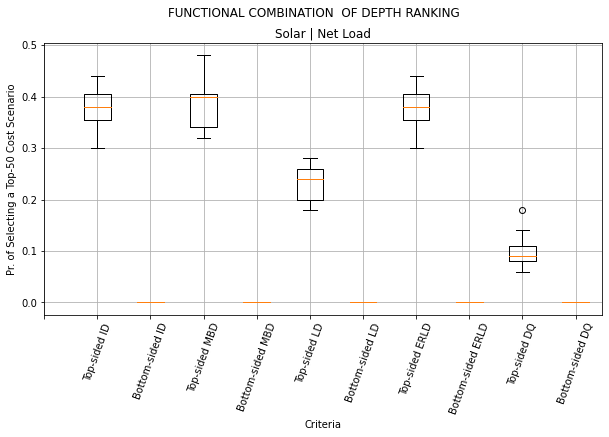

[0.3775 0.     0.3875 0.     0.2325 0.     0.3775 0.     0.1025 0.    ] [0.38 0.   0.4  0.   0.24 0.   0.38 0.   0.09 0.  ]


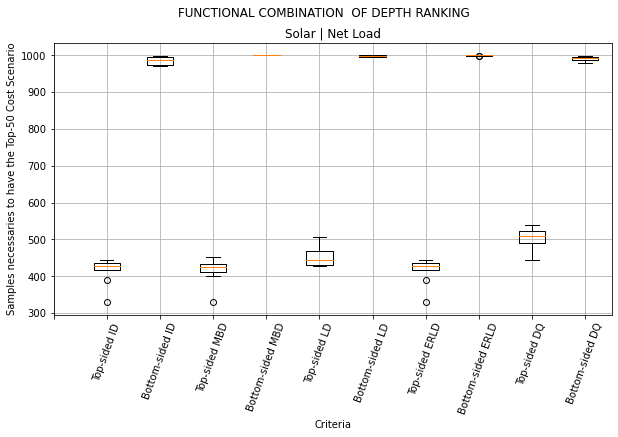

[ 415.75   985.5    415.    1000.     454.25   997.625  415.625  999.5
  502.25   991.125] [ 429.   988.   426.5 1000.   443.5  997.   428.5 1000.   509.5  992.5]
4


<ipython-input-278-cf693d090bb4>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


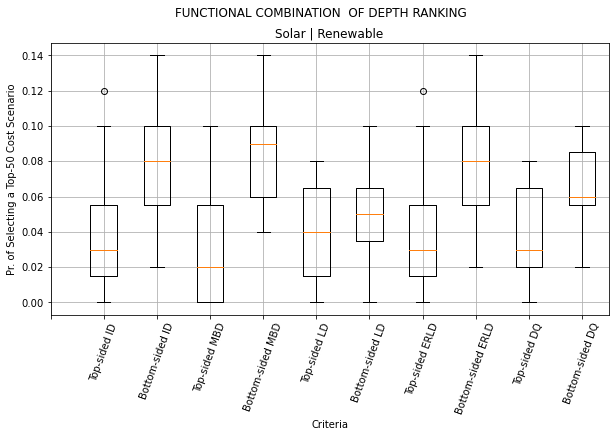

[0.0425 0.0775 0.035  0.085  0.04   0.05   0.0425 0.0775 0.04   0.065 ] [0.03 0.08 0.02 0.09 0.04 0.05 0.03 0.08 0.03 0.06]


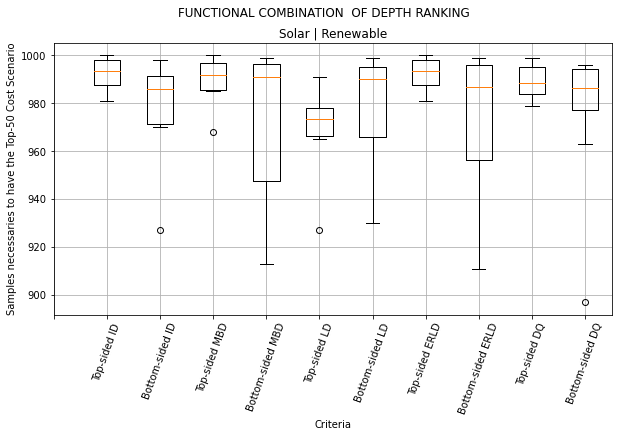

[991.875 978.    989.625 972.625 969.25  976.25  991.875 972.75  988.875
 975.   ] [993.5 986.  992.  991.  973.5 990.  993.5 987.  988.5 986.5]
2
3


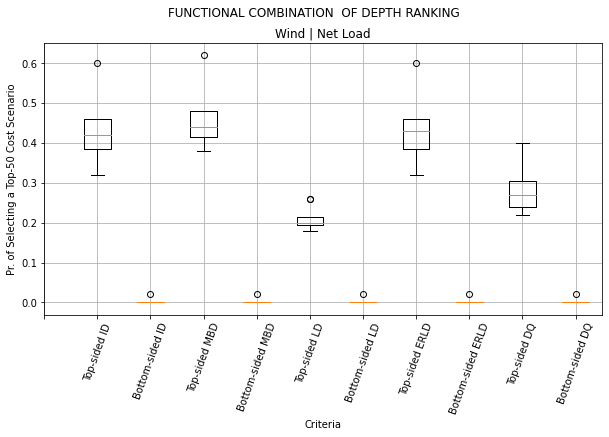

[0.4275 0.0025 0.4575 0.0025 0.21   0.0025 0.43   0.0025 0.2825 0.0025] [0.42 0.   0.44 0.   0.2  0.   0.43 0.   0.27 0.  ]


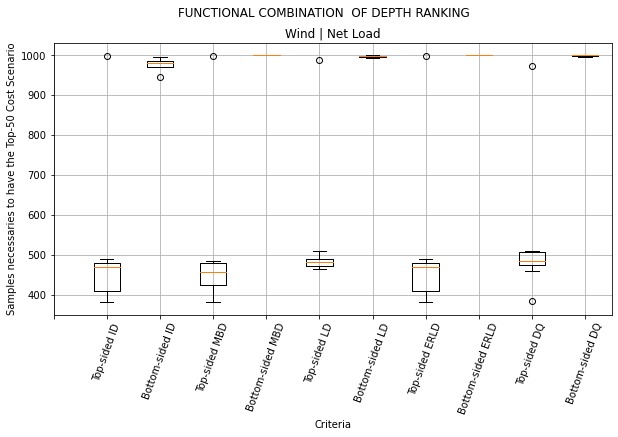

[ 512.     977.5    511.25  1000.     544.625  997.125  512.    1000.
  535.625  999.25 ] [ 470.   980.5  457.5 1000.   483.   997.5  470.  1000.   485.  1000. ]
4


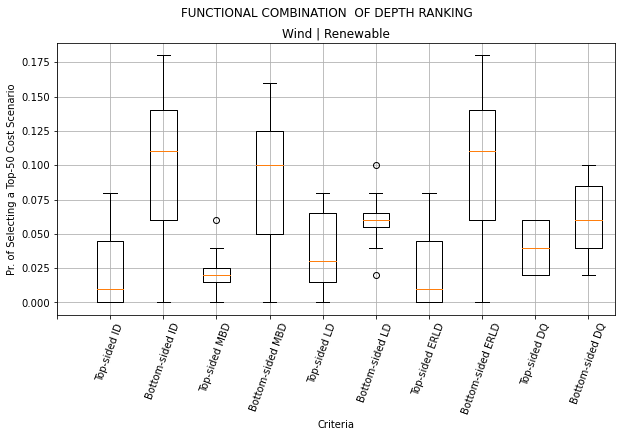

[0.025  0.095  0.0225 0.0875 0.0375 0.06   0.025  0.095  0.04   0.0625] [0.01 0.11 0.02 0.1  0.03 0.06 0.01 0.11 0.04 0.06]


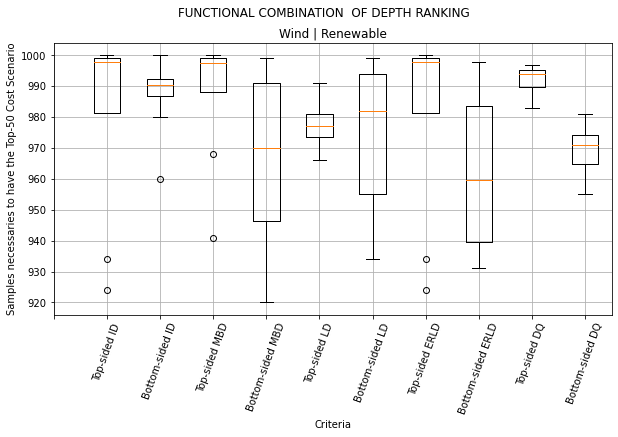

[981.25  986.875 987.25  965.375 977.125 972.875 981.25  962.75  992.
 969.5  ] [998.  990.5 997.5 970.  977.  982.  998.  959.5 994.  971. ]
3
4


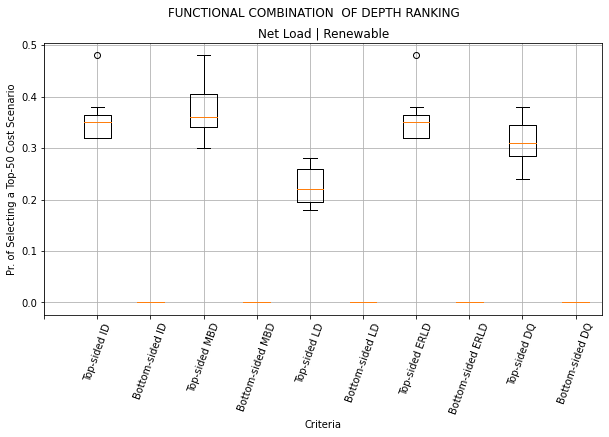

[0.36  0.    0.375 0.    0.225 0.    0.36  0.    0.31  0.   ] [0.35 0.   0.36 0.   0.22 0.   0.35 0.   0.31 0.  ]


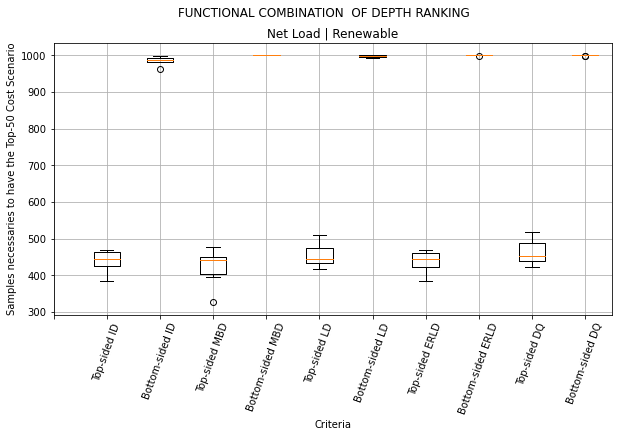

[ 438.25   985.25   423.875 1000.     454.5    997.5    437.75   999.75
  462.375  999.625] [ 444.   987.   442.  1000.   444.5  997.5  444.  1000.   453.5 1000. ]


In [287]:
data_ = [L_, S_, W_, N_, S_ + W_]

names_data_  = ['Load', 'Solar', 'Wind', 'Net Load', 'Renewable']
names_depth_ = ['', 'Top-sided ID',   'Bottom-sided ID', 
                    'Top-sided MBD',  'Bottom-sided MBD',
                    'Top-sided LD',   'Bottom-sided LD', 
                    'Top-sided ERLD', 'Bottom-sided ERLD', 
                    'Top-sided DQ',   'Bottom-sided DQ']

for i in range(len(data_) - 1):
    X_ = data_[i].copy()
    print(i)
    
    for k in range(i + 1, len(data_), 1):
        X_prime_ = data_[k].copy()
        print(k)
            
        F_31_ = np.zeros((N_days, 10))
        F_32_ = np.zeros((N_days, 10))

        for j in range(N_days):
            S_ac_ = np.argsort(Y_[:, 0, j])[::-1]
            
            X_prime_prime_ = np.concatenate((X_[..., j], X_prime_[..., j]), axis = 1)
            
            id_score_, id_rank_     = _ID(X_prime_prime_.T)
            mbd_score_, mbd_rank_   = _MBD(X_prime_prime_.T)
            ld_score_, ld_rank_     = _LinfD(X_prime_prime_.T)
            erld_score_, erld_rank_ = _ERLD(X_prime_prime_.T, method = 'two-sided test')
            dq_score_, dq_rank_     = _DQ(X_prime_prime_.T, method = 'two-sided test', q_ = [.025, .975])
            
            id_rank_geater_ = _geater_deepest(X_prime_prime_.T, id_rank_, N_extreme)
            F_31_[j, 0]     = _score(S_ac_[:N_extreme], id_rank_geater_[:N_extreme])
            F_32_[j, 0]     = _samples(S_ac_, id_rank_geater_, N_extreme)

            id_rank_lesser_ = _lesser_deepest(X_prime_prime_.T, id_rank_, N_extreme)
            F_31_[j, 1]     = _score(S_ac_[:N_extreme], id_rank_lesser_[:N_extreme])
            F_32_[j, 1]     = _samples(S_ac_, dq_rank_lesser_, N_extreme)

            mbd_rank_geater_ = _geater_deepest(X_prime_prime_.T, mbd_rank_, N_extreme)
            F_31_[j, 2]      = _score(S_ac_[:N_extreme], mbd_rank_geater_[:N_extreme])
            F_32_[j, 2]      = _samples(S_ac_, mbd_rank_geater_, N_extreme)

            mbd_rank_lesser_ = _lesser_deepest(X_prime_prime_.T, mbd_rank_, N_extreme)
            F_31_[j, 3]      = _score(S_ac_[:N_extreme], mbd_rank_lesser_[:N_extreme])
            F_32_[j, 3]      = _samples(S_ac_, mbd_rank_lesser_, N_extreme)

            ld_rank_geater_ = _geater_deepest(X_prime_prime_.T, ld_rank_, N_extreme)
            F_31_[j, 4]     = _score(S_ac_[:N_extreme], ld_rank_geater_[:N_extreme])
            F_32_[j, 4]     = _samples(S_ac_, ld_rank_geater_, N_extreme)

            ld_rank_lesser_ = _lesser_deepest(X_prime_prime_.T, ld_rank_, N_extreme)
            F_31_[j, 5]     = _score(S_ac_[:N_extreme], ld_rank_lesser_[:N_extreme])
            F_32_[j, 5]     = _samples(S_ac_, ld_rank_lesser_, N_extreme)

            erld_rank_geater_ = _geater_deepest(X_prime_prime_.T, erld_rank_, N_extreme)
            F_31_[j, 6]       = _score(S_ac_[:N_extreme], erld_rank_geater_[:N_extreme])
            F_32_[j, 6]       = _samples(S_ac_, erld_rank_geater_, N_extreme)

            erld_rank_lesser_ = _lesser_deepest(X_prime_prime_.T, erld_rank_, N_extreme)
            F_31_[j, 7]       = _score(S_ac_[:N_extreme], erld_rank_lesser_[:N_extreme])
            F_32_[j, 7]       = _samples(S_ac_, erld_rank_lesser_, N_extreme)

            dq_rank_geater_ = _geater_deepest(X_prime_prime_.T, dq_rank_, N_extreme)
            F_31_[j, 8]     = _score(S_ac_[:N_extreme], dq_rank_geater_[:N_extreme])
            F_32_[j, 8]     = _samples(S_ac_, dq_rank_geater_, N_extreme)

            dq_rank_lesser_ = _lesser_deepest(X_prime_prime_.T, dq_rank_, N_extreme)
            F_31_[j, 9]     = _score(S_ac_[:N_extreme], dq_rank_lesser_[:N_extreme])
            F_32_[j, 9]     = _samples(S_ac_, dq_rank_lesser_, N_extreme)


        F_ = F_31_.copy()
        
        plt.figure(figsize = (10, 5))
        plt.suptitle('FUNCTIONAL COMBINATION  OF DEPTH RANKING')
        plt.title(names_data_[i] + ' | ' + names_data_[k])
        plt.boxplot([F_[:, l] for l in range(F_.shape[-1])])
        plt.xticks(list(np.arange(len(names_depth_))), names_depth_, rotation = 70)
        plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
        plt.xlabel('Criteria')
        plt.grid()
        plt.show()
        
        print(np.mean(F_, axis = 0), np.median(F_, axis = 0))
        
        F_ = F_32_.copy()
        
        plt.figure(figsize = (10, 5))
        plt.suptitle('FUNCTIONAL COMBINATION  OF DEPTH RANKING')
        plt.title(names_data_[i] + ' | ' + names_data_[k])
        plt.boxplot([F_[:, l] for l in range(F_.shape[-1])])
        plt.xticks(list(np.arange(len(names_depth_))), names_depth_, rotation = 70)
        plt.ylabel('Samples necessaries to have the Top-50 Cost Scenario')
        plt.xlabel('Criteria')
        plt.grid()
        plt.show()
        
        print(np.mean(F_, axis = 0), np.median(F_, axis = 0))

<ipython-input-216-0dd6df6caf42>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


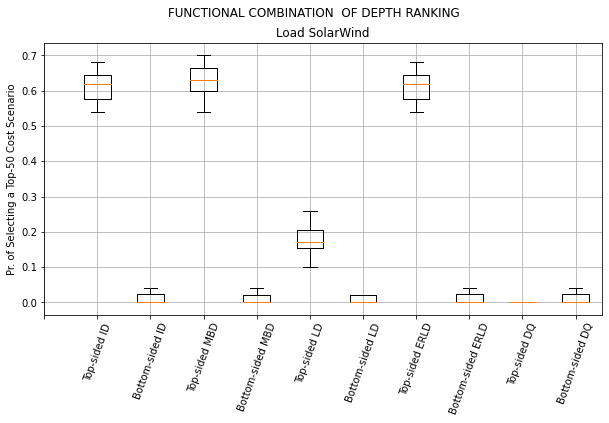

[0.6125 0.0125 0.63   0.01   0.1775 0.0075 0.6125 0.0125 0.     0.0125] [0.62 0.   0.63 0.   0.17 0.   0.62 0.   0.   0.  ]


In [240]:
data_ = [L_, S_, W_, N_, S_ + W_]

names_data_ = ['Load', 'Solar', 'Wind', 'Net Load', 'Renewable']

names_depth_ = ['', 'Top-sided ID',   'Bottom-sided ID', 
                    'Top-sided MBD',  'Bottom-sided MBD',
                    'Top-sided LD',   'Bottom-sided LD', 
                    'Top-sided ERLD', 'Bottom-sided ERLD', 
                    'Top-sided DQ',   'Bottom-sided DQ']

for subset_ in combinations([0, 1, 2, 3, 4], 3):

    i = subset_[0]
    k = subset_[1]
    l = subset_[2]
    print(subset_)
    
    X_             = data_[i].copy()    
    X_prime_       = data_[k].copy()
    X_prime_prime_ = data_[l].copy()

    F_ = np.zeros((N_days, 10))

    for j in range(N_days):
        S_ac_ = np.argsort(Y_[:, 0, j])[::-1][:N_extreme]

        X_prime_prime_prime_ = np.concatenate((X_[..., j], X_prime_[..., j], X_prime_prime_[..., j]), axis = 1)

        id_score_, id_rank_ = _ID(X_prime_prime_prime_.T)
        id_rank_geater_     = _geater_deepest(X_prime_prime_prime_.T, id_rank_, N_extreme)
        F_[j, 0]            = _score(S_ac_, id_rank_geater_)
        id_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_.T, id_rank_, N_extreme)
        F_[j, 1]            = _score(S_ac_, id_rank_lesser_)


        mbd_score_, mbd_rank_ = _MBD(X_prime_prime_prime_.T)
        mbd_rank_geater_      = _geater_deepest(X_prime_prime_prime_.T, mbd_rank_, N_extreme)
        F_[j, 2]              = _score(S_ac_, mbd_rank_geater_)
        mbd_rank_lesser_      = _lesser_deepest(X_prime_prime_prime_.T, mbd_rank_, N_extreme)
        F_[j, 3]              = _score(S_ac_, mbd_rank_lesser_)


        ld_score_, ld_rank_ = _LinfD(X_prime_prime_prime_.T)
        ld_rank_geater_     = _geater_deepest(X_prime_prime_prime_.T, ld_rank_, N_extreme)
        F_[j, 4]            = _score(S_ac_, ld_rank_geater_)
        ld_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_.T, ld_rank_, N_extreme)
        F_[j, 5]            = _score(S_ac_, ld_rank_lesser_)


        erld_score_, erld_rank_ = _ERLD(X_prime_prime_prime_.T, method = 'two-sided test')
        erld_rank_geater_       = _geater_deepest(X_prime_prime_prime_.T, erld_rank_, N_extreme)
        F_[j, 6]                = _score(S_ac_, erld_rank_geater_)
        erld_rank_lesser_       = _lesser_deepest(X_prime_prime_prime_.T, erld_rank_, N_extreme)
        F_[j, 7]                = _score(S_ac_, erld_rank_lesser_)


        dq_score_, dq_rank_ = _DQ(X_prime_prime_prime_.T, method = 'two-sided test', q_ = [.025, .975])
        dq_rank_geater_     = _geater_deepest(X_prime_prime_prime_.T, dq_rank_, N_extreme)
        F_[j, 8]            = _score(S_ac_, dq_rank_geater_)
        dq_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_.T, dq_rank_, N_extreme)
        F_[j, 9]            = _score(S_ac_, dq_rank_lesser_)

    plt.figure(figsize = (10, 5))
    plt.suptitle('FUNCTIONAL COMBINATION  OF DEPTH RANKING')
    plt.title(names_data_[i] + ' | ' + names_data_[k] + ' | ' + names_data_[l])
    plt.boxplot([F_[:, l] for l in range(F_.shape[-1])])
    plt.xticks(list(np.arange(len(names_depth_))), names_depth_, rotation = 70)
    plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
    plt.grid()
    plt.show()

    print(np.mean(F_, axis = 0), np.median(F_, axis = 0))

(0, 1, 2, 3)


<ipython-input-216-0dd6df6caf42>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


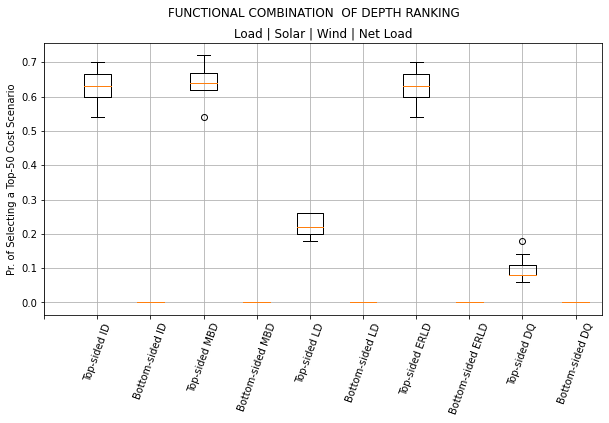

[0.63   0.     0.6425 0.     0.225  0.     0.63   0.     0.1    0.    ] [0.63 0.   0.64 0.   0.22 0.   0.63 0.   0.08 0.  ]
(0, 1, 2, 4)


<ipython-input-216-0dd6df6caf42>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


KeyboardInterrupt: 

In [243]:
data_ = [L_, S_, W_, N_, S_ + W_]

names_data_ = ['Load', 'Solar', 'Wind', 'Net Load', 'Renewable']

names_depth_ = ['', 'Top-sided ID',   'Bottom-sided ID', 
                    'Top-sided MBD',  'Bottom-sided MBD',
                    'Top-sided LD',   'Bottom-sided LD', 
                    'Top-sided ERLD', 'Bottom-sided ERLD', 
                    'Top-sided DQ',   'Bottom-sided DQ']

for subset_ in combinations([0, 1, 2, 3, 4], 4):
   
    i = subset_[0]
    k = subset_[1]
    l = subset_[2]
    m = subset_[3] 
    print(subset_)

    X_                   = data_[i].copy()    
    X_prime_             = data_[k].copy()
    X_prime_prime_       = data_[l].copy()
    X_prime_prime_prime_ = data_[m].copy()


    F_ = np.zeros((N_days, 10))

    for j in range(N_days):
        S_ac_ = np.argsort(Y_[:, 0, j])[::-1][:N_extreme]

        X_prime_prime_prime_prime_ = np.concatenate((X_[..., j], X_prime_[..., j], X_prime_prime_[..., j], X_prime_prime_prime_[..., j]), axis = 1)

        id_score_, id_rank_ = _ID(X_prime_prime_prime_prime_.T)
        id_rank_geater_     = _geater_deepest(X_prime_prime_prime_prime_.T, id_rank_, N_extreme)
        F_[j, 0]            = _score(S_ac_, id_rank_geater_)
        id_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_prime_.T, id_rank_, N_extreme)
        F_[j, 1]            = _score(S_ac_, id_rank_lesser_)


        mbd_score_, mbd_rank_ = _MBD(X_prime_prime_prime_prime_.T)
        mbd_rank_geater_      = _geater_deepest(X_prime_prime_prime_prime_.T, mbd_rank_, N_extreme)
        F_[j, 2]              = _score(S_ac_, mbd_rank_geater_)
        mbd_rank_lesser_      = _lesser_deepest(X_prime_prime_prime_prime_.T, mbd_rank_, N_extreme)
        F_[j, 3]              = _score(S_ac_, mbd_rank_lesser_)


        ld_score_, ld_rank_ = _LinfD(X_prime_prime_prime_prime_.T)
        ld_rank_geater_     = _geater_deepest(X_prime_prime_prime_prime_.T, ld_rank_, N_extreme)
        F_[j, 4]            = _score(S_ac_, ld_rank_geater_)
        ld_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_prime_.T, ld_rank_, N_extreme)
        F_[j, 5]            = _score(S_ac_, ld_rank_lesser_)


        erld_score_, erld_rank_ = _ERLD(X_prime_prime_prime_prime_.T, method = 'two-sided test')
        erld_rank_geater_       = _geater_deepest(X_prime_prime_prime_prime_.T, erld_rank_, N_extreme)
        F_[j, 6]                = _score(S_ac_, erld_rank_geater_)
        erld_rank_lesser_       = _lesser_deepest(X_prime_prime_prime_prime_.T, erld_rank_, N_extreme)
        F_[j, 7]                = _score(S_ac_, erld_rank_lesser_)


        dq_score_, dq_rank_ = _DQ(X_prime_prime_prime_prime_.T, method = 'two-sided test', q_ = [.025, .975])
        dq_rank_geater_     = _geater_deepest(X_prime_prime_prime_prime_.T, dq_rank_, N_extreme)
        F_[j, 8]            = _score(S_ac_, dq_rank_geater_)
        dq_rank_lesser_     = _lesser_deepest(X_prime_prime_prime_prime_.T, dq_rank_, N_extreme)
        F_[j, 9]            = _score(S_ac_, dq_rank_lesser_)

    plt.figure(figsize = (10, 5))
    plt.suptitle('FUNCTIONAL COMBINATION  OF DEPTH RANKING')
    plt.title(names_data_[i] + ' | ' + names_data_[k] + ' | ' + names_data_[l] + ' | ' + names_data_[m])
    plt.boxplot([F_[:, l] for l in range(F_.shape[-1])])
    plt.xticks(list(np.arange(len(names_depth_))), names_depth_, rotation = 70)
    plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
    plt.grid()
    plt.show()

    print(np.mean(F_, axis = 0), np.median(F_, axis = 0))

<ipython-input-216-0dd6df6caf42>:134: RuntimeWarning: invalid value encountered in true_divide
  DQ_[~idx_lower_] = Y_prime_[~idx_lower_]/np.absolute(Q_upper_[~idx_lower_])


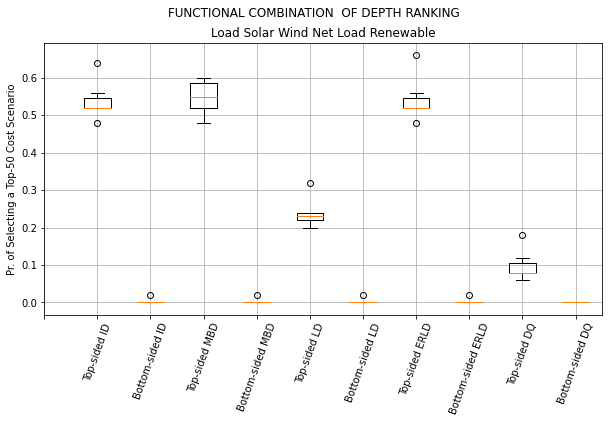

[0.5375 0.0025 0.55   0.0025 0.2375 0.0025 0.54   0.0025 0.0975 0.    ] [0.52 0.   0.55 0.   0.23 0.   0.52 0.   0.08 0.  ]


In [241]:
data_ = [L_, S_, W_, N_, S_ + W_]

names_data_ = ['Load', 'Solar', 'Wind', 'Net Load', 'Renewable']

names_depth_ = ['', 'Top-sided ID',   'Bottom-sided ID', 
                    'Top-sided MBD',  'Bottom-sided MBD',
                    'Top-sided LD',   'Bottom-sided LD', 
                    'Top-sided ERLD', 'Bottom-sided ERLD', 
                    'Top-sided DQ',   'Bottom-sided DQ']

F_ = np.zeros((N_days, 10))

for j in range(N_days):
    S_ac_ = np.argsort(Y_[:, 0, j])[::-1][:N_extreme]

    X_prime_ = np.concatenate((data_[0][..., j], data_[1][..., j], data_[2][..., j], data_[3][..., j], data_[4][..., j]), axis = 1)

    id_score_, id_rank_ = _ID(X_prime_.T)
    id_rank_geater_     = _geater_deepest(X_prime_.T, id_rank_, N_extreme)
    F_[j, 0]            = _score(S_ac_, id_rank_geater_)
    id_rank_lesser_     = _lesser_deepest(X_prime_.T, id_rank_, N_extreme)
    F_[j, 1]            = _score(S_ac_, id_rank_lesser_)


    mbd_score_, mbd_rank_ = _MBD(X_prime_.T)
    mbd_rank_geater_      = _geater_deepest(X_prime_.T, mbd_rank_, N_extreme)
    F_[j, 2]              = _score(S_ac_, mbd_rank_geater_)
    mbd_rank_lesser_      = _lesser_deepest(X_prime_.T, mbd_rank_, N_extreme)
    F_[j, 3]              = _score(S_ac_, mbd_rank_lesser_)


    ld_score_, ld_rank_ = _LinfD(X_prime_.T)
    ld_rank_geater_     = _geater_deepest(X_prime_.T, ld_rank_, N_extreme)
    F_[j, 4]            = _score(S_ac_, ld_rank_geater_)
    ld_rank_lesser_     = _lesser_deepest(X_prime_.T, ld_rank_, N_extreme)
    F_[j, 5]            = _score(S_ac_, ld_rank_lesser_)


    erld_score_, erld_rank_ = _ERLD(X_prime_.T, method = 'two-sided test')
    erld_rank_geater_       = _geater_deepest(X_prime_.T, erld_rank_, N_extreme)
    F_[j, 6]                = _score(S_ac_, erld_rank_geater_)
    erld_rank_lesser_       = _lesser_deepest(X_prime_.T, erld_rank_, N_extreme)
    F_[j, 7]                = _score(S_ac_, erld_rank_lesser_)


    dq_score_, dq_rank_ = _DQ(X_prime_.T, method = 'two-sided test', q_ = [.025, .975])
    dq_rank_geater_     = _geater_deepest(X_prime_.T, dq_rank_, N_extreme)
    F_[j, 8]            = _score(S_ac_, dq_rank_geater_)
    dq_rank_lesser_     = _lesser_deepest(X_prime_.T, dq_rank_, N_extreme)
    F_[j, 9]            = _score(S_ac_, dq_rank_lesser_)

plt.figure(figsize = (10, 5))
plt.suptitle('FUNCTIONAL COMBINATION  OF DEPTH RANKING')
plt.title(names_data_[0] + ' | ' + names_data_[1] + ' | ' + names_data_[2] + ' | ' + names_data_[3] + ' | ' + names_data_[4])
plt.boxplot([F_[:, l] for l in range(F_.shape[-1])])
plt.xticks(list(np.arange(len(names_depth_))), names_depth_, rotation = 70)
plt.ylabel('Pr. of Selecting a Top-50 Cost Scenario')
plt.grid()
plt.show()

print(np.mean(F_, axis = 0), np.median(F_, axis = 0))

In [ ]:
        
# Compute Functional Envelop
def _functional_envelop(Y_, id_rank_, alpha):
    N_scenarios = Y_.shape[-1]
    # Number of Functions within Functional Interval
    N_prime = N_scenarios - int(N_scenarios*alpha)
    print(N_prime, id_rank_.shape)
    Y_prime_ = Y_[:, id_rank_[-N_prime:]]

    # Compute Functional Interval Stats   
    f_upper_ = np.max(Y_prime_, axis = 1)
    f_lower_ = np.min(Y_prime_, axis = 1)
    f_mean_  = np.mean(Y_prime_, axis = 1)
    
    return f_upper_, f_lower_, f_mean_